## Project Framework

### 1. Target Definition
- News signals are generally short-lived; therefore, the focus is on **short-horizon SPY returns**.
- The prediction horizon is **determined during the feature analysis stage**, prior to model training and portfolio backtesting.

### 2. Data Preparation & Alignment
- Ingest the news dataset and aggregate headlines to a **daily frequency**.
- Align news features with SPY returns using a **one-day lag** to avoid look-ahead bias, given the absence of intraday timestamps and the possibility that some headlines are released after market close.

### 3. Feature Construction & Economic Intuition
- **News volume:** Daily headline counts as a proxy for information flow and market activity.
- **Sentiment:**
  - Counts of positive, negative, and neutral headlines
  - Average sentiment score
  - Constructed at both the **aggregate level** and the **category level** (category counts and category-level sentiment)
- **Complexity:** Measures of headline complexity, where unusually complex or long headlines may signal more impactful information.
- All features are **normalized using rolling time-series z-scores** with a 90-day window and **winsorized at the 1st and 99th percentiles**.

### 4. Modeling Choices
- **Sentiment:** Use `twitter-roberta-base-sentiment`, a well-validated model optimized for short, headline-style text, as a strong and reproducible baseline.
- **Complexity:** Use readability-based proxies (e.g., Gunning Fog, Dale–Chall, Flesch) and finance-oriented complexity lexicons where applicable.

### 5. Feature-Level Analysis
- Evaluate the standalone behavior of individual features using **Sharpe ratios** and **correlation-based metrics**.

### 6. Modeling Process
- Apply **time-series-based cross-validation** throughout.
- Evaluate a focused set of models, including **XGBoost**, **Random Forest**, and **LightGBM**.
- Explore **model ensembling** to combine complementary signals.

### 7. Prediction Assessment
- Analyze and visualize predictive performance across models using **R²** and **RMSE**.
- Evaluate **risk-neutralized prediction performance** by regressing out common equity risk factors using data from the **Kenneth French Data Library**.

### 8. Portfolio Construction & Backtesting
- Construct **long–short portfolios** based on individual model predictions as well as the ensemble signal.
- Analyze backtest performance (e.g., Sharpe ratio, drawdown, turnover).
- Assess **factor-neutral portfolio performance** after neutralizing common risk factors using data from the Kenneth French Data Library.

In [1]:
# Install required packages
# Run this cell first if you encounter ModuleNotFoundError
# Option 1: Install from requirements.txt (recommended)
# !pip install -r requirements.txt

# Option 2: Install packages individually (including safetensors to avoid torch version issues)
# Uncomment the line below to install all packages:
# !pip install pandas "numpy>=1.23.0,<2.0.0" scikit-learn transformers torch safetensors textstat matplotlib seaborn yfinance xgboost lightgbm

# Option 3: Install via terminal/command line:
# pip install -r requirements.txt

# Quick install for missing packages:
# !pip install xgboost         # For XGBoost model
# !pip install lightgbm        # For LightGBM model

# IMPORTANT NOTES:
# 1. NumPy Compatibility: PyTorch 2.2.2 requires NumPy < 2.0.0. If you encounter NumPy 2.x compatibility errors,
#    downgrade NumPy: !pip install "numpy<2.0.0"
# 2. If you encounter a ValueError about torch.load requiring torch>=2.6,
#    install safetensors: !pip install safetensors
#    The notebook will automatically use safetensors if available to bypass the torch version requirement.
# 3. PyArrow is required for sentiment caching (parquet file support):
#    If using conda: !conda install -c conda-forge pyarrow
#    If using pip: !pip install pyarrow
#    Or install from requirements.txt which includes pyarrow
# 4. yfinance is required for downloading SPY data:
#    !pip install yfinance
# 5. xgboost and lightgbm are required for model training:
#    !pip install xgboost lightgbm


In [2]:
# News Sentiment Analysis for SPY Returns Prediction
# This notebook implements a comprehensive pipeline for predicting next-day SPY returns
# using news sentiment, volume, complexity, and uncertainty features

# Standard library imports
import json
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Date/time utilities
from datetime import datetime, timedelta

# Set style for plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 0. Function Definitions

All analysis functions are defined below for modularity and reusability.


In [3]:
# Data Loading and Preparation
from data_loader import DataLoader
print("DataLoader class imported!")

# DATA EXPLORATION AND STATISTICS FUNCTIONS
from data_explorer import DataExplorer
print("DataExplorer class imported!")

# FEATURE ENGINEERING FUNCTIONS (on individual articles)
from feature_extractor import ArticleFeatureExtractor
print("Feature extraction class imported!")

# # FEATURE AGGREGATION, NORMALIZATION, AND ANALYSIS
from feature_analyzer import FeatureAnalyzer
print("FeatureAnalyzer class imported!")

# MODELING FUNCTIONS
from model import NewsSentimentModeler
print("NewsSentimentModeler class imported!")

# BACKTESTING FUNCTIONS
from strategy_backtest import StrategyBacktester
print("StrategyBacktester class imported!")

DataLoader class imported!
DataExplorer class imported!
/Users/ayx/Documents/Projects/news
Feature extraction class imported!
FeatureAnalyzer class imported!
NewsSentimentModeler class imported!
StrategyBacktester class imported!


## 1. Data Loading and Preparation

### 1.1 Load News Dataset


In [4]:
# Load news dataset using DataLoader class
data_loader = DataLoader()
df_news = data_loader.load_news_dataset()
df_news.head()


Loading news dataset...
Loaded 209,527 news articles
Date range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00

Categories: 42
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
Name: count, dtype: int64


,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/dwight-ho...,Dwight Howard Rips Teammates After Magic Loss ...,SPORTS,The five-time all-star center tore into his te...,,2012-01-28
1,https://www.huffingtonpost.com/entry/robots-pl...,"Robots Play Catch, Starring Agile Justin And R...",SCIENCE,"image 1: throw As Hizook reports, DLR started ...",Travis Korte,2012-01-28
2,https://www.huffingtonpost.com/entry/russian-c...,Russian Cargo Ship Docks At International Spac...,SCIENCE,Gallery: Space Station's Expedition 30 Mission...,,2012-01-28
3,https://www.huffingtonpost.com/entry/7-amazing...,7 Amazing Name Generators (PHOTOS),COMEDY,Let's be honest: most of our names are pretty ...,Seena Vali,2012-01-28
4,https://www.huffingtonpost.com/entry/mitt-romn...,Mitt Romney Madness: Florida Edition (VIDEO),COMEDY,The apparent madness that gripped Mitt Romney ...,Ben Craw,2012-01-28


In [5]:
# Compute and display statistics
data_explorer = DataExplorer()
df_news, daily_counts, monthly_counts, category_counts = data_explorer.compute_news_statistics(df_news)


NEWS DATASET STATISTICS

Dataset Overview:
- Total articles: 209,527
- Date range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00
- Number of unique categories: 42
- Number of unique dates: 3890

Headline Statistics:
- Average tokens per headline: 9.6
- Median tokens per headline: 10.0
- Average characters per headline: 58.4

Daily News Statistics:
- Average news per day: 53.9
- Median news per day: 74.0
- Max news in a single day: 100
- Min news in a single day: 2

Monthly News Statistics:
- Average news per month: 1624.2
- Total months covered: 129

Top 15 Categories:
category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
Name: count, dtype: int64


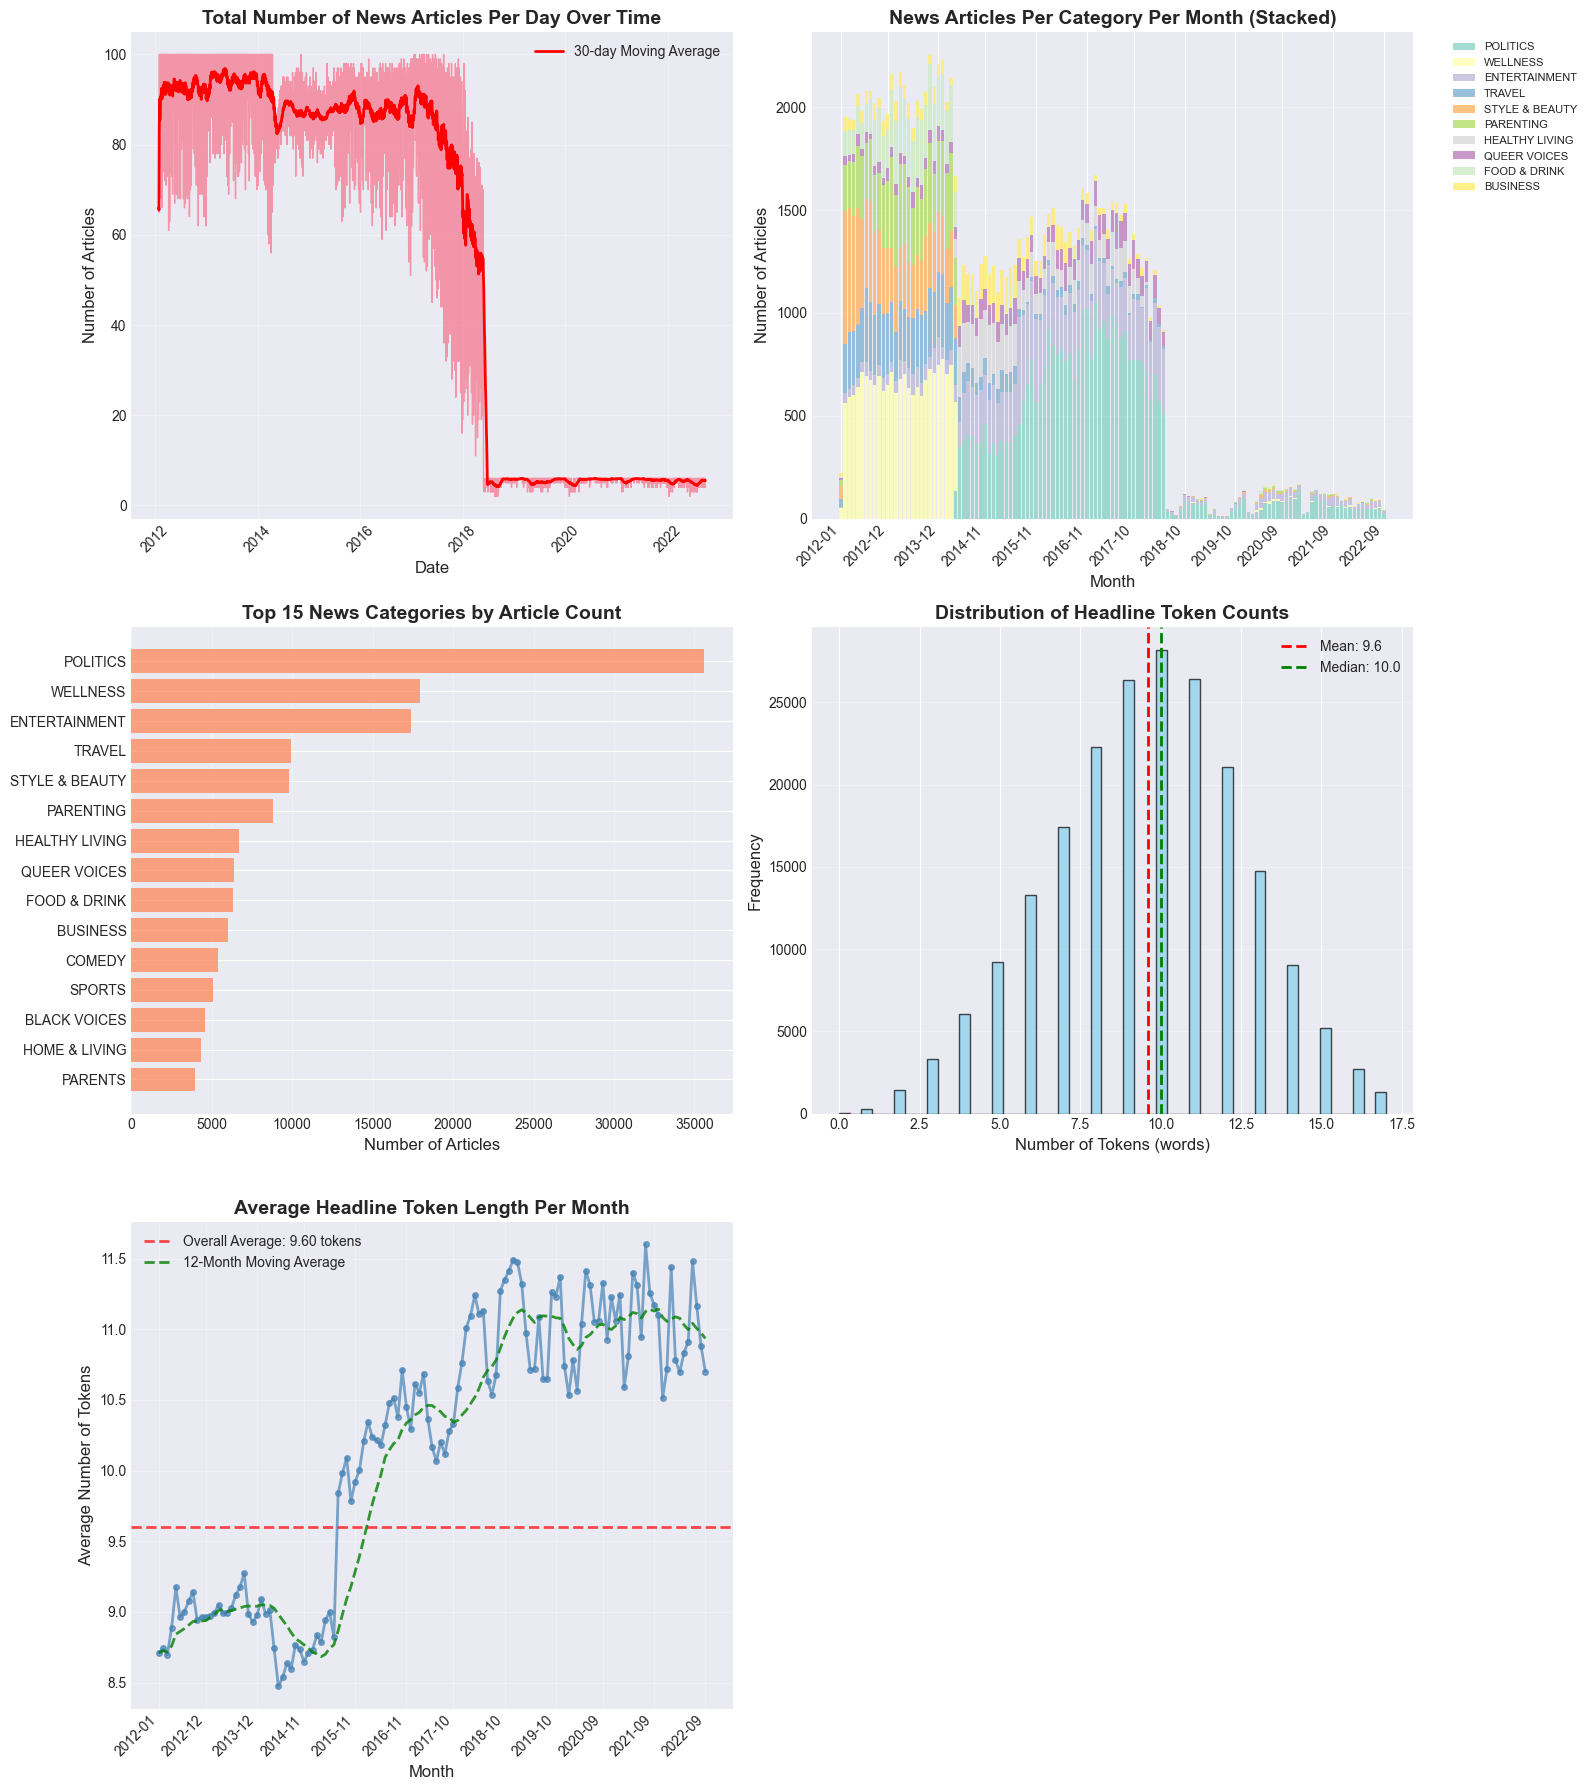


Visualizations created!

Average headline token length statistics:
- Overall average: 9.60 tokens
- Monthly average range: 8.47 - 11.60 tokens
- Monthly average std: 0.96 tokens


In [6]:
# Create visualizations
data_explorer.plot_news_statistics(df_news, daily_counts, monthly_counts, category_counts)


## Observation Summary

### 1. News Volume Over Time
- From **2012 to mid-2018**, the dataset exhibits a **stable and high daily volume** of news articles, averaging roughly **80–100 articles per day**, with moderate short-term fluctuations.
- Around **mid-2018**, there is a **sharp structural break**, after which daily article counts drop dramatically to fewer than **10 articles per day**.
- This discontinuity likely reflects a **data collection or coverage change**, rather than a genuine collapse in news production.
- **Implication:** Post-2018 data may not be directly comparable to earlier periods, requiring regime-aware modeling or robustness checks.

---

### 2. Category Composition Over Time
- Prior to 2018, **Politics, Wellness, Entertainment, and Lifestyle-related categories** dominate overall article volume.
- The category mix is relatively stable over time, with cyclical variation within individual categories.
- After 2018, article counts across **all categories decline simultaneously**, reinforcing the interpretation of a **dataset-level structural break**.
- **Implication:** Category-level features are more informative pre-2018 and may suffer from sparsity afterward.

---

### 3. Category Distribution (Cross-Section)
- **Politics** is by far the most frequent category, followed by **Wellness** and **Entertainment**.
- Business-related articles represent a **smaller fraction** of total headlines.
- This skew suggests that predictive signals extracted from the dataset are likely driven by **broad risk sentiment and macro narratives**, rather than firm-level fundamentals.

---

### 4. Headline Length Distribution
- Headline length is tightly distributed, with:
  - **Mean ≈ 9.6 tokens**
  - **Median ≈ 10 tokens**
- The narrow distribution indicates headlines are **short and standardized**
- Extreme outliers are rare, reducing noise from anomalously long text.

---

### 5. Headline Length Over Time (Complexity Proxy)
- Average headline length increases gradually from **2012 to 2018**, rising from approximately **8.7 to 11 tokens**.
- After 2018, headline length stabilizes around **11 tokens**, with modest month-to-month variation.
- This suggests a **slow shift in editorial style** toward more descriptive or nuanced headlines.
- **Implication:** Raw complexity measures are non-stationary; relative or demeaned features are preferred.

---

### 6. Implications for Feature Engineering and Modeling
- The **2018 structural break** is the most significant characteristic of the dataset and should be explicitly addressed.
- Volume-based features require **normalization or regime-aware interpretation**.
- Sentiment, complexity, and uncertainty features are well-defined given the consistency in headline length.
- Relative (“surprise”) features are likely more informative than absolute levels due to long-term stylistic drift.

---

### Summary Takeaway
Overall, the dataset exhibits **stable structure and rich variation prior to 2018**, making it well-suited for extracting short-horizon news-based signals. In contrast, the **post-2018 period shows a clear structural shift**, which may partly reflect **data sourcing or coverage changes** rather than genuine regime effects. 

In [7]:
# Load SPY returns data using DataLoader class
df_spy = data_loader.load_spy_returns()
print(f"\nDataset shape: {df_spy.shape}")
print(f"Columns: {list(df_spy.columns)}")
df_spy.head()


SPY data loaded: 24,608 trading days
Date range: 1928-01-03 00:00:00 to 2025-12-18 00:00:00

Return statistics:
count    24608.000000
mean         0.000242
std          0.011953
min         -0.228997
25%         -0.004551
50%          0.000501
75%          0.005454
max          0.153661
Name: spy_return, dtype: float64

Dataset shape: (24608, 4)
Columns: ['date', 'SP500', 'spy_return', 'spy_return_next']


,date,SP500,spy_return,spy_return_next
1,1928-01-03,17.760000,0.005647,-0.002255
2,1928-01-04,17.719999,-0.002255,-0.009640
3,1928-01-05,17.549999,-0.009640,0.006248
4,1928-01-06,17.660000,0.006248,-0.009101
5,1928-01-09,17.500000,-0.009101,-0.007456


## 1. Data Loading and Preparation

### 1.1 Load News Dataset


In [8]:
extractor = ArticleFeatureExtractor(data_loader=data_loader)

Loading Loughran-McDonald uncertainty words from data/Loughran-McDonald_MasterDictionary_1993-2024.csv...
Loaded 285 uncertainty words from Loughran-McDonald dictionary
Sample words: ['abeyances', 'somewhere', 'conceivable', 'clarifications', 'confuses', 'presumed', 'suggest', 'variants', 'depended', 'exposures']
Loading sentiment model...


`torch_dtype` is deprecated! Use `dtype` instead!
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using device: cpu
Model loaded on device: cpu


In [9]:
# Compute features on individual articles
# Create ArticleFeatureExtractor instance (sentiment model will be initialized automatically)
df_features = extractor.compute_all_features(df_news, reload_cache=True)
df_features.head()

Computing features on individual articles...
Computing complexity features...
Computing uncertainty features...
Loaded 209,527 sentiment results from data/cache/sentiment_cache.parquet
Features computed for 209,527 articles


,link,headline,category,short_description,authors,date,headline_tokens,headline_length,year_month,flesch,...,gunning_fog_normalized,dale_chall_normalized,complexity,uncertainty_count,uncertainty_ratio,sentiment_label,sentiment_score,sentiment_negative,sentiment_neutral,sentiment_positive
0,https://www.huffingtonpost.com/entry/dwight-ho...,Dwight Howard Rips Teammates After Magic Loss ...,SPORTS,The five-time all-star center tore into his te...,,2012-01-28,9,56,2012-01,66.100,...,NaN,NaN,NaN,0,0.0,neutral,-0.318328,0.344627,0.629073,0.026300
1,https://www.huffingtonpost.com/entry/robots-pl...,"Robots Play Catch, Starring Agile Justin And R...",SCIENCE,"image 1: throw As Hizook reports, DLR started ...",Travis Korte,2012-01-28,10,67,2012-01,44.405,...,NaN,NaN,NaN,0,0.0,neutral,0.071751,0.012370,0.903509,0.084121
2,https://www.huffingtonpost.com/entry/russian-c...,Russian Cargo Ship Docks At International Spac...,SCIENCE,Gallery: Space Station's Expedition 30 Mission...,,2012-01-28,8,55,2012-01,40.090,...,NaN,NaN,NaN,0,0.0,neutral,-0.011990,0.043569,0.924853,0.031579
3,https://www.huffingtonpost.com/entry/7-amazing...,7 Amazing Name Generators (PHOTOS),COMEDY,Let's be honest: most of our names are pretty ...,Seena Vali,2012-01-28,5,34,2012-01,15.640,...,NaN,NaN,NaN,0,0.0,positive,0.937695,0.006029,0.050248,0.943724
4,https://www.huffingtonpost.com/entry/mitt-romn...,Mitt Romney Madness: Florida Edition (VIDEO),COMEDY,The apparent madness that gripped Mitt Romney ...,Ben Craw,2012-01-28,6,44,2012-01,3.345,...,NaN,NaN,NaN,0,0.0,neutral,0.043920,0.023460,0.909160,0.067380


## 2. Feature Aggregation, Normalization, and Analysis

This section aggregates article-level features to daily frequency, merges with category-specific features, applies normalization, aligns with SPY returns, and performs feature analysis.


In [10]:
# Aggregate and normalize features (daily + by category)
# This function:
# 1. Aggregates features to daily frequency (overall)
# 2. Aggregates features to daily frequency by category  
# 3. Merges both with category_feature_name columns
# 4. Applies rolling window z-score normalization
feature_analyzer = FeatureAnalyzer()
daily_features = feature_analyzer.aggregate_and_normalize_features(
    df_features,
    window_size=90,
    min_periods=30
)
print(f"\nFeatures shape: {daily_features.shape}")
print(f"Feature columns: {len([c for c in daily_features.columns if c != 'date'])}")
print(f"\nFirst few rows:")
daily_features.head()


Aggregating and normalizing features
Aggregating features to daily frequency...
Aggregated to 3,890 unique dates
Average headlines per day: 53.9
Aggregating features to daily frequency by category...
Aggregated to 44,094 date-category combinations
Unique categories: 42
Date range: 2012-01-28 00:00:00 to 2022-09-23 00:00:00

Preparing category features for merge...
Merged features: 3,890 rows, 216 columns
Normalizing 215 features using rolling window z-score...
Window size: 90 days, Min periods: 30

Feature aggregation and normalization complete
Clipped 215 normalized features at 1st and 99th percentiles

Features shape: (3890, 431)
Feature columns: 430

First few rows:


,date,sentiment_score,complexity,average_token_length,headline_count,sentiment_ratio,ARTS_average_token_length,ARTS & CULTURE_average_token_length,BLACK VOICES_average_token_length,BUSINESS_average_token_length,...,TECH_sentiment_score_normalized,THE WORLDPOST_sentiment_score_normalized,TRAVEL_sentiment_score_normalized,U.S. NEWS_sentiment_score_normalized,WEDDINGS_sentiment_score_normalized,WEIRD NEWS_sentiment_score_normalized,WELLNESS_sentiment_score_normalized,WOMEN_sentiment_score_normalized,WORLD NEWS_sentiment_score_normalized,WORLDPOST_sentiment_score_normalized
0,2012-01-28,0.115905,2.194922,9.257576,66,0.090909,NaN,NaN,NaN,8.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-01-29,-0.008572,2.301621,8.338462,65,-0.030769,NaN,NaN,7.666667,7.857143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-01-30,0.003290,2.466778,8.780000,100,-0.080000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-01-31,0.066248,2.351000,8.520000,100,0.050000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-02-01,0.101706,2.423050,9.120000,100,0.020000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Align features with SPY returns using one-day lag
# Features from day t-1 are used to predict returns on day t
df_merged = feature_analyzer.align_features_with_spy(daily_features, df_spy)
print(f"\nMerged dataset shape: {df_merged.shape}")
print(f"Date range: {df_merged['date'].min()} to {df_merged['date'].max()}")



Aligning features with SPY returns...
Applying one-day lag to 430 feature columns...
Final merged dataset: 2,681 observations
Date range: 2012-01-31 00:00:00 to 2022-09-23 00:00:00
Features aligned: 430 original + 430 lagged

Merged dataset shape: (2681, 863)
Date range: 2012-01-31 00:00:00 to 2022-09-23 00:00:00


In [12]:
# Keep only *_normalized_lag features and remove the '_normalized_lag' suffix from column names
# This keeps only the normalized lagged features for modeling
normalized_lag_cols = [col for col in df_merged.columns if col.endswith('_normalized_lag')]

# Create a new dataframe with only normalized lagged features
df_features_clean = df_merged[['date', 'spy_return', 'spy_return_next'] + normalized_lag_cols].copy()

# Remove '_normalized_lag' suffix from feature column names
rename_dict = {col: col.replace('_normalized_lag', '') for col in normalized_lag_cols}
df_features_clean = df_features_clean.rename(columns=rename_dict)

print(f"Kept {len(normalized_lag_cols)} normalized lagged features")
print(f"Final dataset shape: {df_features_clean.shape}")

Kept 215 normalized lagged features
Final dataset shape: (2681, 218)


### 2.0 Horizon Analysis

Evaluate multiple forward return horizons (e.g., 1D, 2D, 3D, 4D, 5D, 7D, 10D, 14D) to determine the most appropriate prediction target for news-derived signals.  
For each horizon, we assess signal alignment and tradeability **in the following priority order**:

1. **Sharpe (primary):** long–short strategy Sharpe constructed from each feature/signal group  
2. **Spearman (secondary):** rank-based association between features and forward returns  
3. **Pearson (tertiary):** linear correlation between features and forward returns  

Results are summarized by signal category (sentiment, complexity, token-length, volume) to capture differences in information decay across feature families. The selected horizon is fixed before model training and backtesting.

FEATURE GROUPS GENERATED

Total features: 215
Number of groups: 4

Group breakdown:
  complexity: 43 features
  sentiment: 86 features
  token_length: 43 features
  volume: 43 features
HORIZON SELECTION ANALYSIS (Sharpe-First Priority)

Analyzing horizons: [1, 2, 3, 4, 5, 7, 10, 14] days
Feature groups: ['sentiment', 'complexity', 'token_length', 'volume']

Step 1: Computing forward returns...

Step 2: Computing feature-level metrics...
Total features to analyze: 215
Computed metrics for 1720 feature-horizon combinations

Step 3: Aggregating by group...

GROUP-LEVEL STATISTICS BY HORIZON

COMPLEXITY:
------------------------------------------------------------
 horizon  median_sharpe  top_quartile_sharpe  max_sharpe  count_sharpe_pos  median_spearman  top_quartile_spearman  median_pearson  n_features
       1       0.184883             0.360296    0.574260                32         0.002826               0.014053       -0.004259          43
       2       0.107647             0.285927 

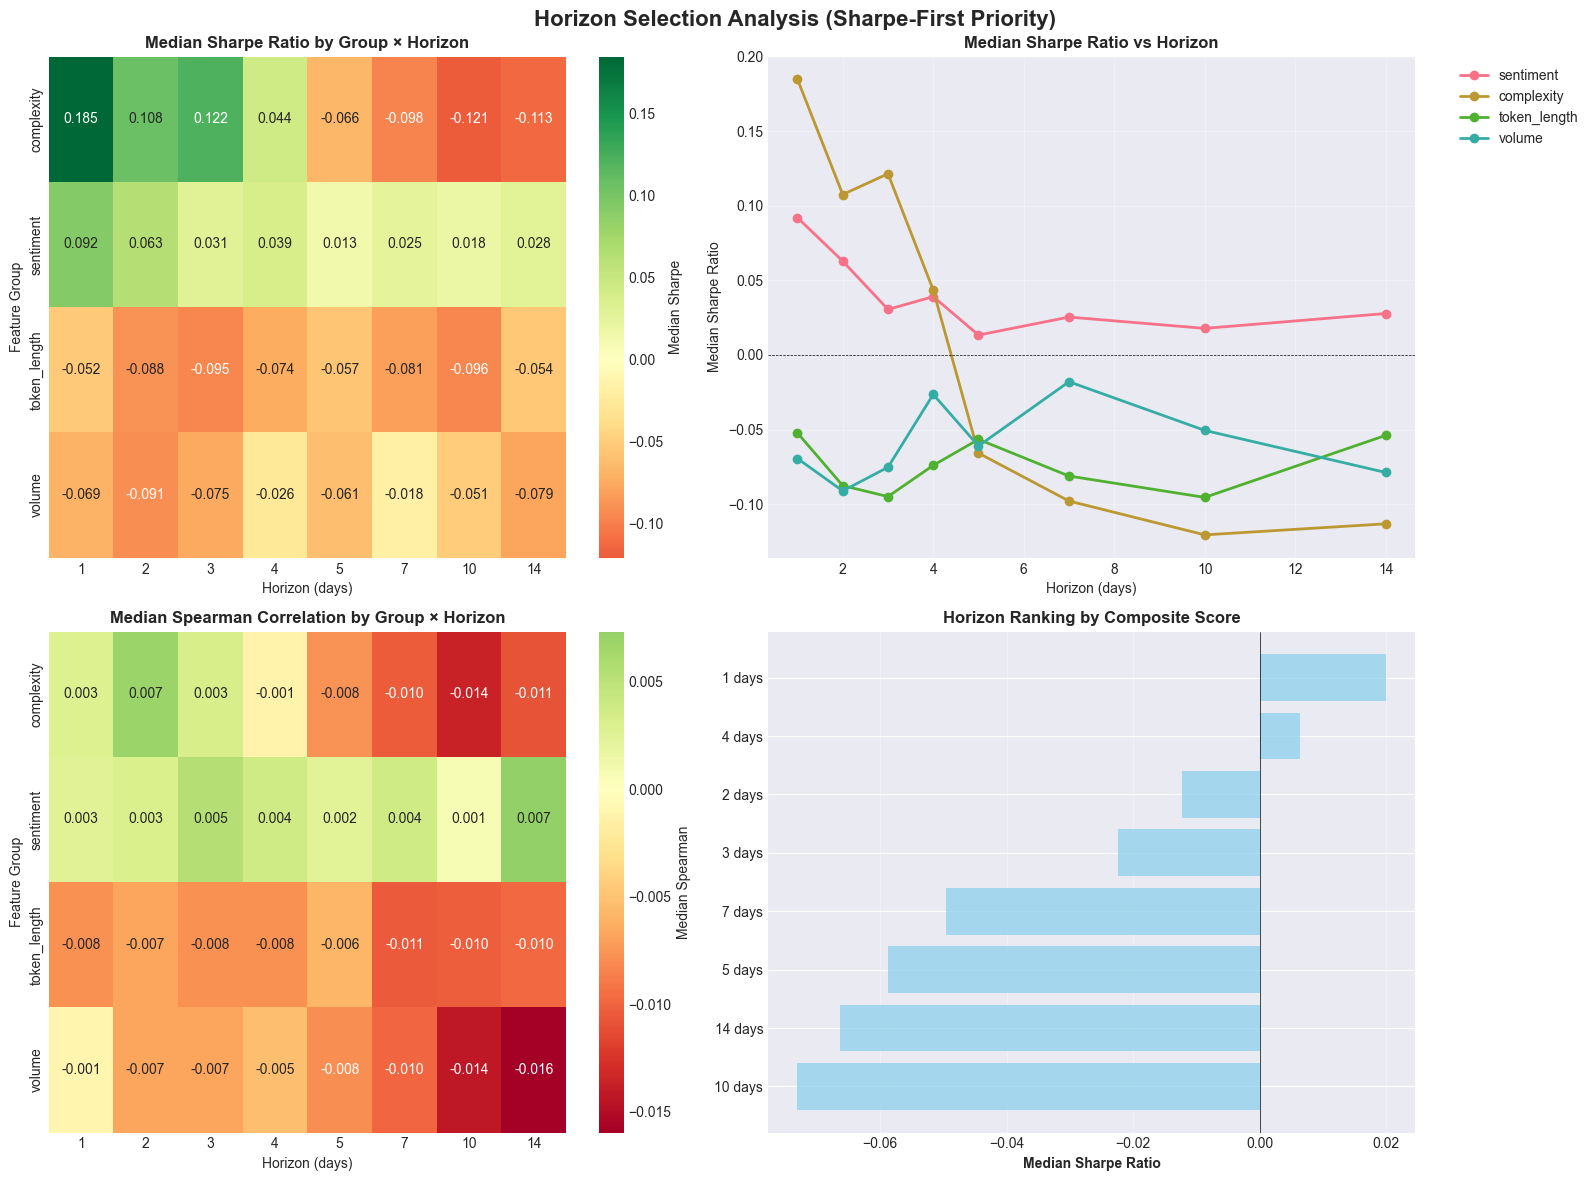

(<Figure size 1600x1200 with 6 Axes>,
 array([[<Axes: title={'center': 'Median Sharpe Ratio by Group × Horizon'}, xlabel='Horizon (days)', ylabel='Feature Group'>,
         <Axes: title={'center': 'Median Sharpe Ratio vs Horizon'}, xlabel='Horizon (days)', ylabel='Median Sharpe Ratio'>],
        [<Axes: title={'center': 'Median Spearman Correlation by Group × Horizon'}, xlabel='Horizon (days)', ylabel='Feature Group'>,
         <Axes: title={'center': 'Horizon Ranking by Composite Score'}, xlabel='Median Sharpe Ratio'>]],
       dtype=object))

In [13]:
feature_cols = [col for col in df_features_clean.columns 
                       if col not in ['date', 'spy_return', 'spy_return_next']]
feature_groups = feature_analyzer.generate_feature_groups(feature_cols)
horizons = [1, 2, 3, 4, 5, 7, 10, 14]
results = feature_analyzer.analyze_horizon_selection(df_features_clean, feature_groups, horizons)
feature_analyzer.plot_horizon_analysis(results)


### Horizon Selection Summary (Sharpe-First)


- The **1-day horizon** ranks highest overall, driven by the strongest median Sharpe and broad participation across features.
- **2–4 day horizons** form a secondary tier, showing moderate but decaying signal strength.
- Horizons **beyond 5 days** consistently underperform, with median Sharpe turning negative across most signal groups.

By signal type:
- **Complexity signals** exhibit strong short-horizon behavior (1–3 days) with rapid decay.
- **Sentiment signals** are more persistent, remaining positive across short to medium horizons.
- **Token-length and volume features** show weak performance across all horizons.

Based on these results, the **1-day forward return** is selected as the primary prediction target.
**Token-length and volume-based features are excluded from the modeling stage.**

In [14]:
# remove all features that end with _token_length and _headline_count
df_features_clean = df_features_clean.drop(columns=[col for col in df_features_clean.columns if col.endswith('_token_length') or col.endswith('_headline_count')])
feature_cols_clean = [c for c in df_features_clean.columns if c not in ['date', 'spy_return', 'spy_return_next']]


### 2.1 Feature-Level Analysis

Use data from 2012 to 2018 to Evaluate the standalone behavior of individual features using correlation and information coefficients, complemented by simple long–short return analyses, to assess their directional consistency.


In [15]:
# Analyze all features and create summary table

df_features_is = df_features_clean[df_features_clean['date'] < '2019-12-31'].copy()
feature_analysis_results = feature_analyzer.analyze_all_features(df_features_is)


### 2.2 Feature Visualization

Visualize the top features ranked by different performance measures.


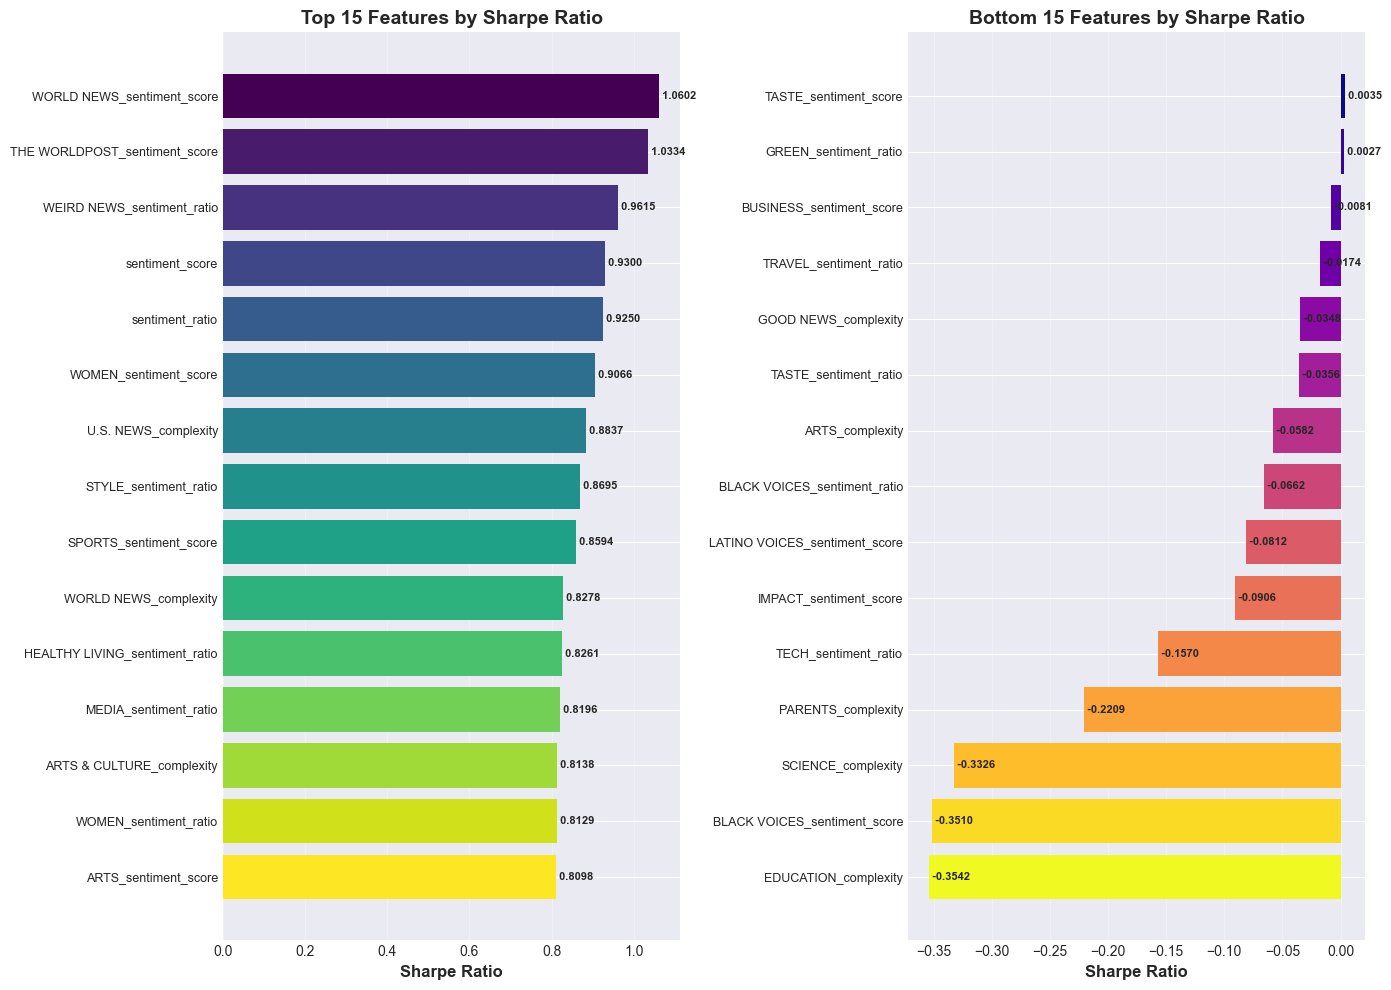

(<Figure size 1400x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Top 15 Features by Sharpe Ratio'}, xlabel='Sharpe Ratio'>,
        <Axes: title={'center': 'Bottom 15 Features by Sharpe Ratio'}, xlabel='Sharpe Ratio'>],
       dtype=object))

In [16]:
# Visualize top 30 features by Sharpe ratio
feature_analyzer.plot_top_features(feature_analysis_results, measure='sharpe_ratio', top_n=15)


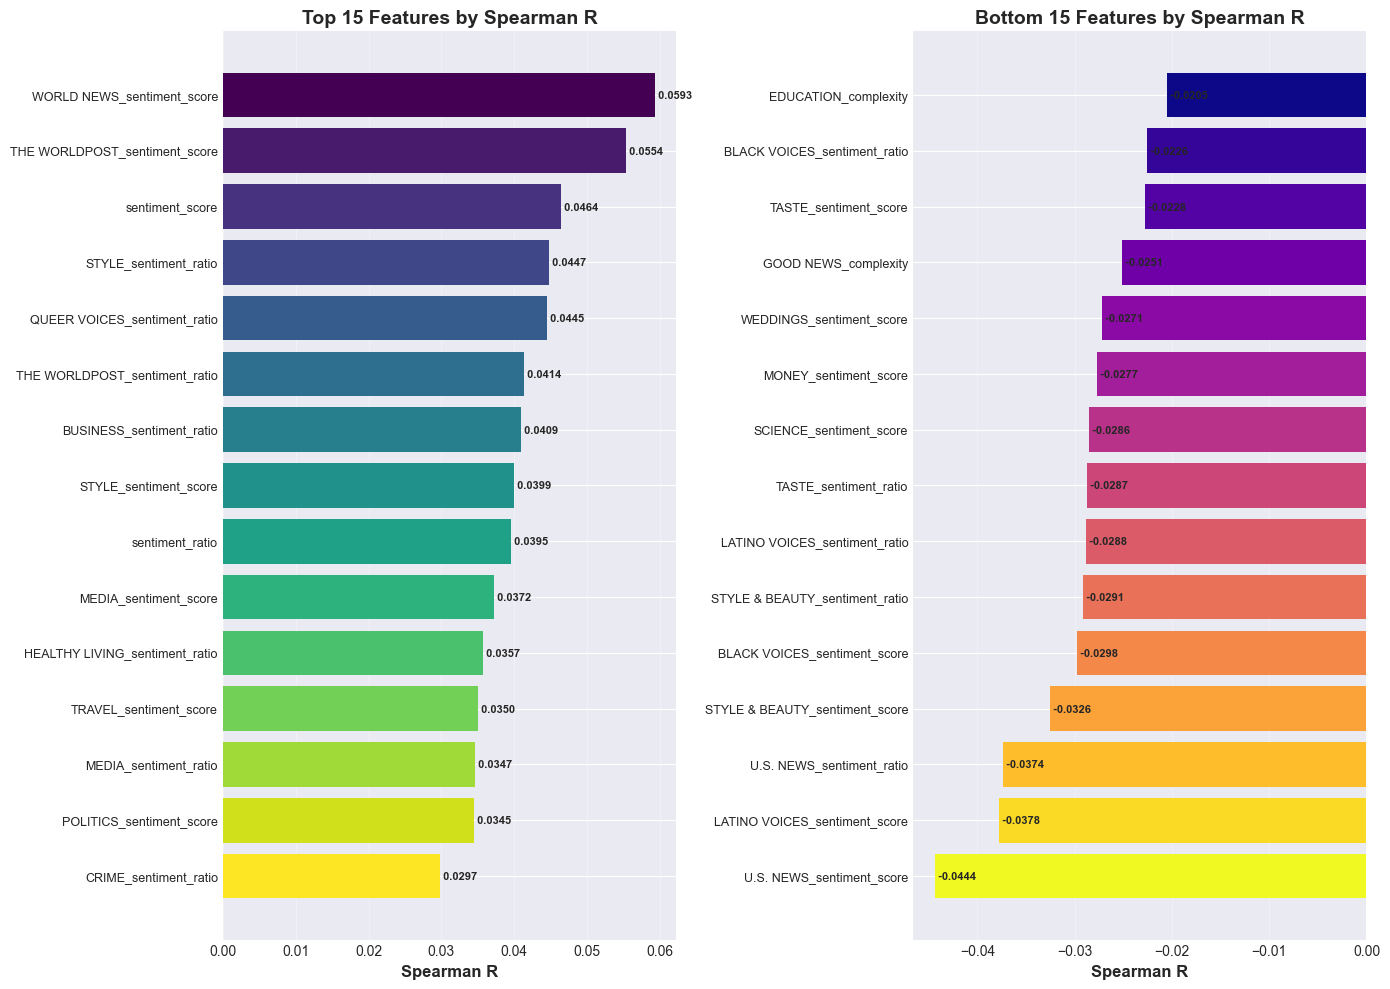

(<Figure size 1400x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Top 15 Features by Spearman R'}, xlabel='Spearman R'>,
        <Axes: title={'center': 'Bottom 15 Features by Spearman R'}, xlabel='Spearman R'>],
       dtype=object))

In [17]:
# Visualize top 30 features by Pearson correlation
feature_analyzer.plot_top_features(feature_analysis_results, measure='spearman_r', top_n=15)


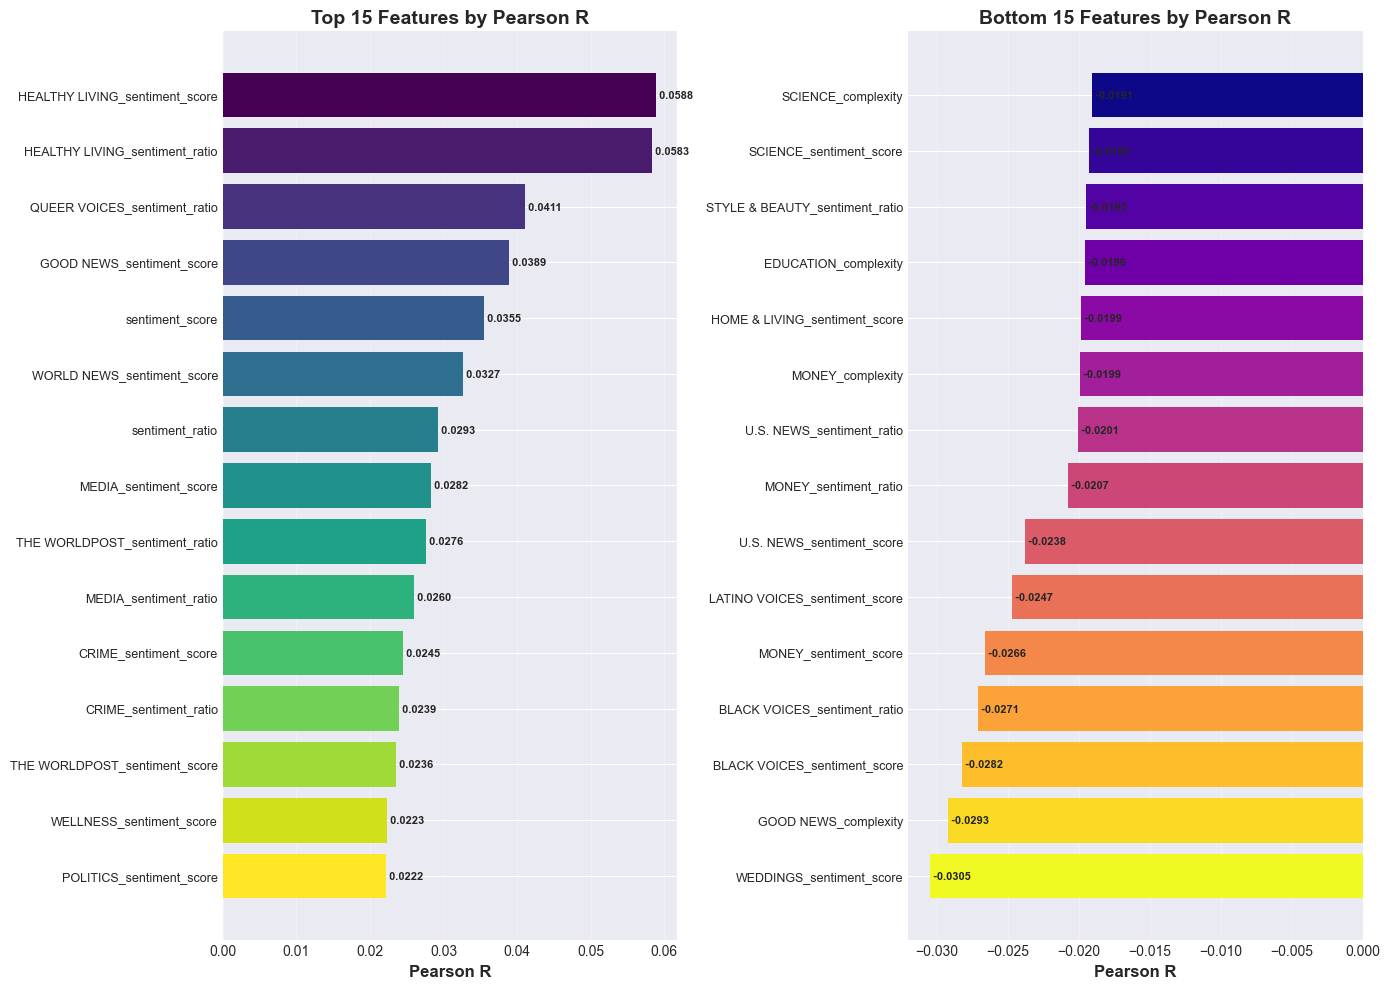

(<Figure size 1400x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Top 15 Features by Pearson R'}, xlabel='Pearson R'>,
        <Axes: title={'center': 'Bottom 15 Features by Pearson R'}, xlabel='Pearson R'>],
       dtype=object))

In [18]:
# Visualize top 30 features by Pearson correlation
feature_analyzer.plot_top_features(feature_analysis_results, measure='pearson_r', top_n=15)


### 2.3 Feature Pairwise Correlation Analysis

Analyze correlations between features to identify multicollinearity and redundant features.


Computing pearson pairwise correlations for 127 features...


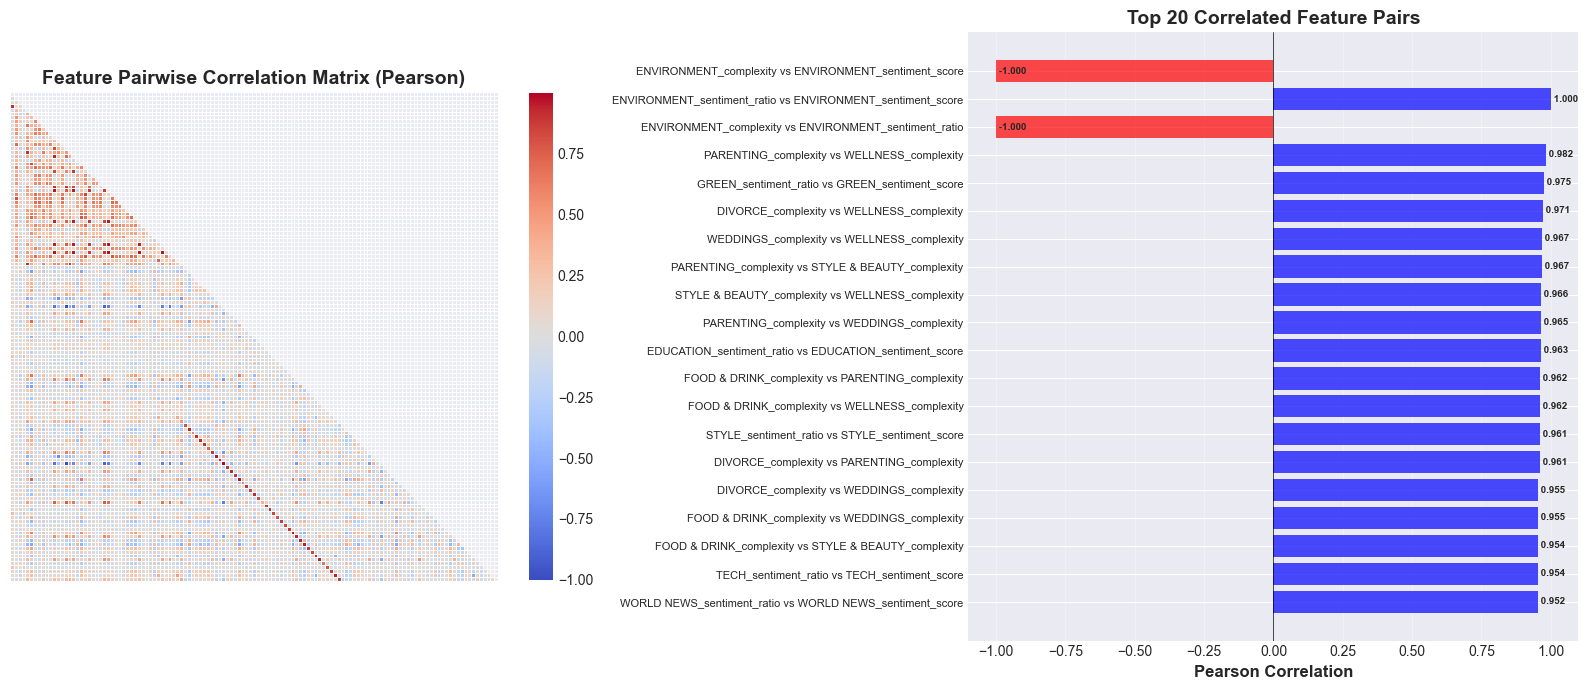


Correlation Summary:
  Total feature pairs: 8001
  Mean absolute correlation: 0.9686
  Max absolute correlation: 1.0000
  Min absolute correlation: 0.9523

Top 20 correlated pairs:
                  feature_1                   feature_2  correlation
     ENVIRONMENT_complexity ENVIRONMENT_sentiment_score    -1.000000
ENVIRONMENT_sentiment_ratio ENVIRONMENT_sentiment_score     0.999882
     ENVIRONMENT_complexity ENVIRONMENT_sentiment_ratio    -0.999882
       PARENTING_complexity         WELLNESS_complexity     0.981999
      GREEN_sentiment_ratio       GREEN_sentiment_score     0.975472
         DIVORCE_complexity         WELLNESS_complexity     0.971030
        WEDDINGS_complexity         WELLNESS_complexity     0.967408
       PARENTING_complexity   STYLE & BEAUTY_complexity     0.966868
  STYLE & BEAUTY_complexity         WELLNESS_complexity     0.965642
       PARENTING_complexity         WEDDINGS_complexity     0.965037
  EDUCATION_sentiment_ratio   EDUCATION_sentiment_score    

In [19]:
# Analyze pairwise correlations between features
corr_matrix, top_correlations = feature_analyzer.analyze_pairwise_correlations(
    df_features_is, 
    feature_cols=feature_cols_clean,
    method='pearson',
    figsize=(16, 14),
    top_pairs=20
)


Analyzing distributions for 127 features...


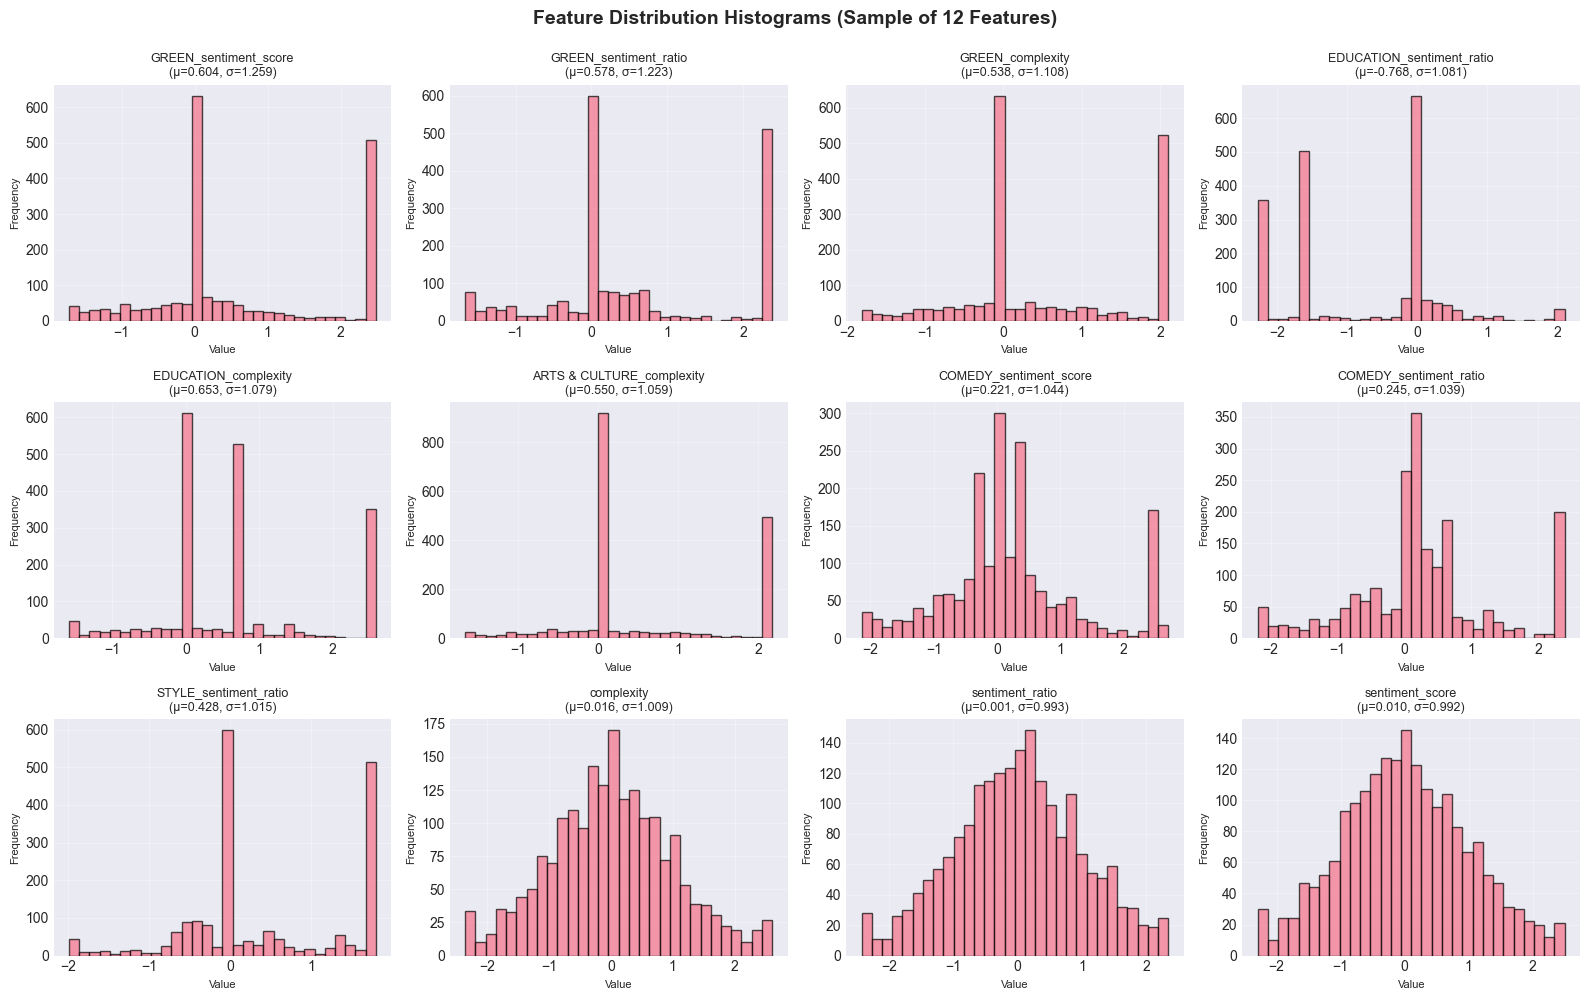

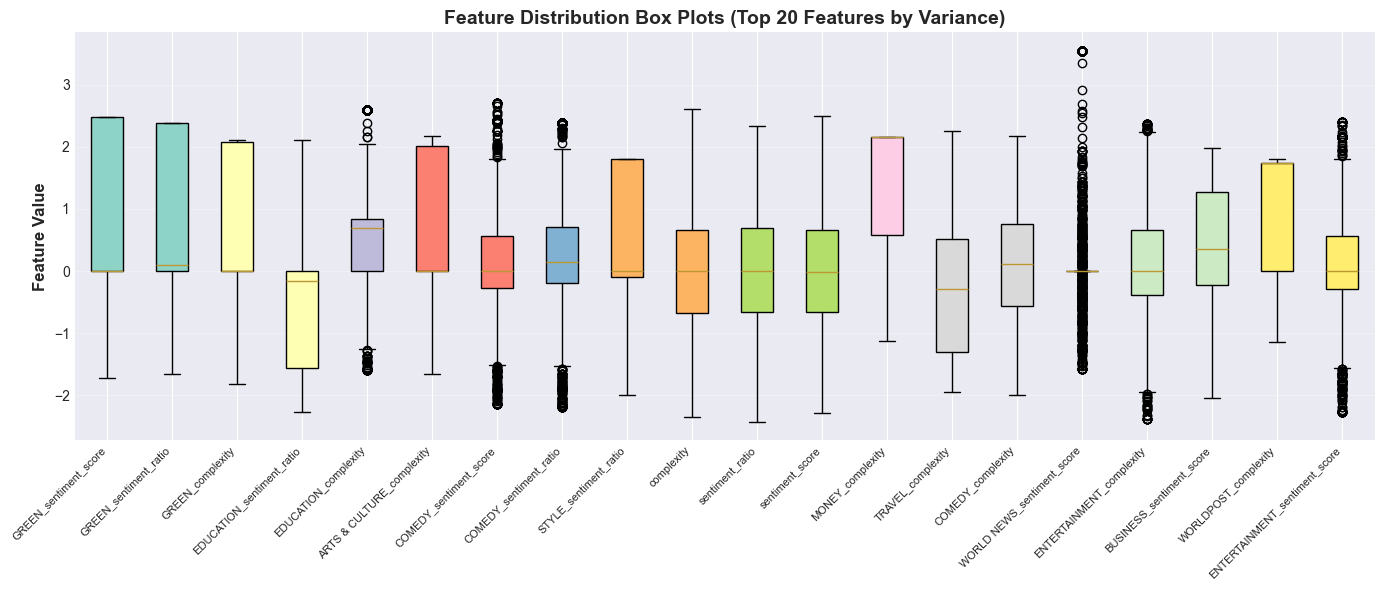

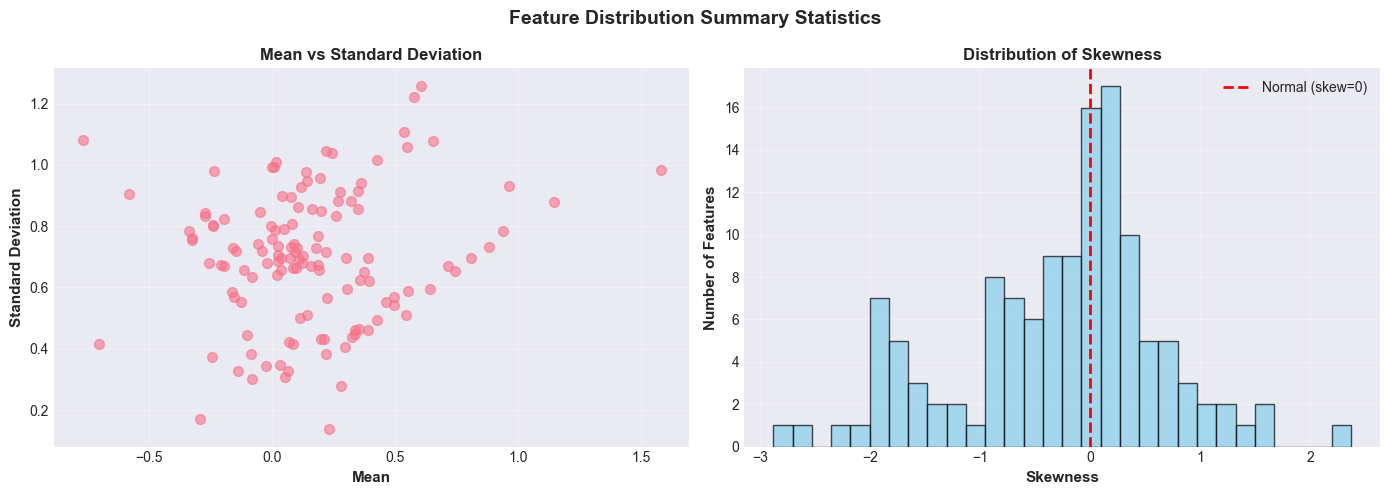


Distribution analysis complete


In [20]:
# Analyze feature distributions
stats_df = feature_analyzer.analyze_feature_distributions(df_features_is, feature_cols_clean)

### Feature Analysis Summary (Exploratory Diagnostics)

This section summarizes what is learned from basic distribution and correlation diagnostics on the engineered daily news features (overall + per-category).

#### Dataset coverage
- **~210 engineered features** are created over **~1,992 daily observations**.

#### Scale and normalization
- Core aggregated features such as `sentiment_score`, `sentiment_ratio`, `complexity` appear **roughly standardized** (means near 0, standard deviations near 1).  

#### Feature distributions: non-Gaussian + sparsity effects
- Many features are **approximately symmetric** (skewness near 0), but a meaningful subset exhibits **heavy tails / outliers** (high kurtosis).

#### High correlation of some features
- Pairwise correlations are high for some features like sentiment ratio and sentiment score, not suitable for standard OLS model

#### Cross-Metric Observations

- Sentiment-based features (both aggregate and category-level) appear frequently among the top-ranked features in **both Pearson correlation and Sharpe ratio**.
- Complexity features exhibit mixed behavior: some perform strongly on a Sharpe basis despite weaker linear correlation, while others consistently rank near the bottom across both metrics.

## 3. Model Training and Evaluation

This section trains predictive models using Random Forest, XGBoost, and LightGBM with time series cross-validation. Models are evaluated on test (2020-2021) and out-of-sample (2022) sets. An ensemble model (weighted: 80% XGBoost, 10% LightGBM, 10% Random Forest) is also included.


In [21]:
# Run the complete modeling pipeline
# This will:
# 1. Split data into train (2012-2019), test (2020-2021), and out-of-sample (2022) sets
# 2. Check if hyperparameters file exists - if yes, load models; if no, train with TSCV
# 3. Evaluate all models (including ensemble) on test and out-of-sample sets
# 4. Return results summary

modeler = NewsSentimentModeler()
# remove all features that end with _token_length and _headline_count
df_features_clean = df_features_clean.drop(columns=[col for col in df_features_clean.columns if col.endswith('_token_length') or col.endswith('_headline_count')])
results_summary = modeler.run_full_pipeline(
    df_features_clean,
    cv_folds=5,
    hyperparameters_file='model_hyperparameters.json', 
    overwrite=False
)

print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(results_summary.to_string(index=False))


DATA SPLIT SUMMARY
Training set: 1,993 observations
  Date range: 2012-01-31 00:00:00 to 2019-12-31 00:00:00

Test set: 505 observations
  Date range: 2020-01-02 00:00:00 to 2021-12-31 00:00:00

Out-of-sample set: 183 observations
  Date range: 2022-01-03 00:00:00 to 2022-09-23 00:00:00

HYPERPARAMETERS FILE FOUND: model_hyperparameters.json
LOADING MODELS FROM SAVED HYPERPARAMETERS

Hyperparameters loaded from model_hyperparameters.json
LOADED HYPERPARAMETERS SUMMARY

RANDOM FOREST:
  Hyperparameters: {'max_depth': 2, 'min_samples_split': 100, 'n_estimators': 500}
  CV R²: -0.0301 (±0.0266)

XGBOOST:
  Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
  CV R²: -0.0553 (±0.0365)

LIGHTGBM:
  Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31}
  CV R²: -0.0486 (±0.0326)

RECREATING MODELS FROM SAVED HYPERPARAMETERS

Recreating Random Forest model...
  Trained with {'max_depth': 2, 'min_samples_split': 100, 'n_estima

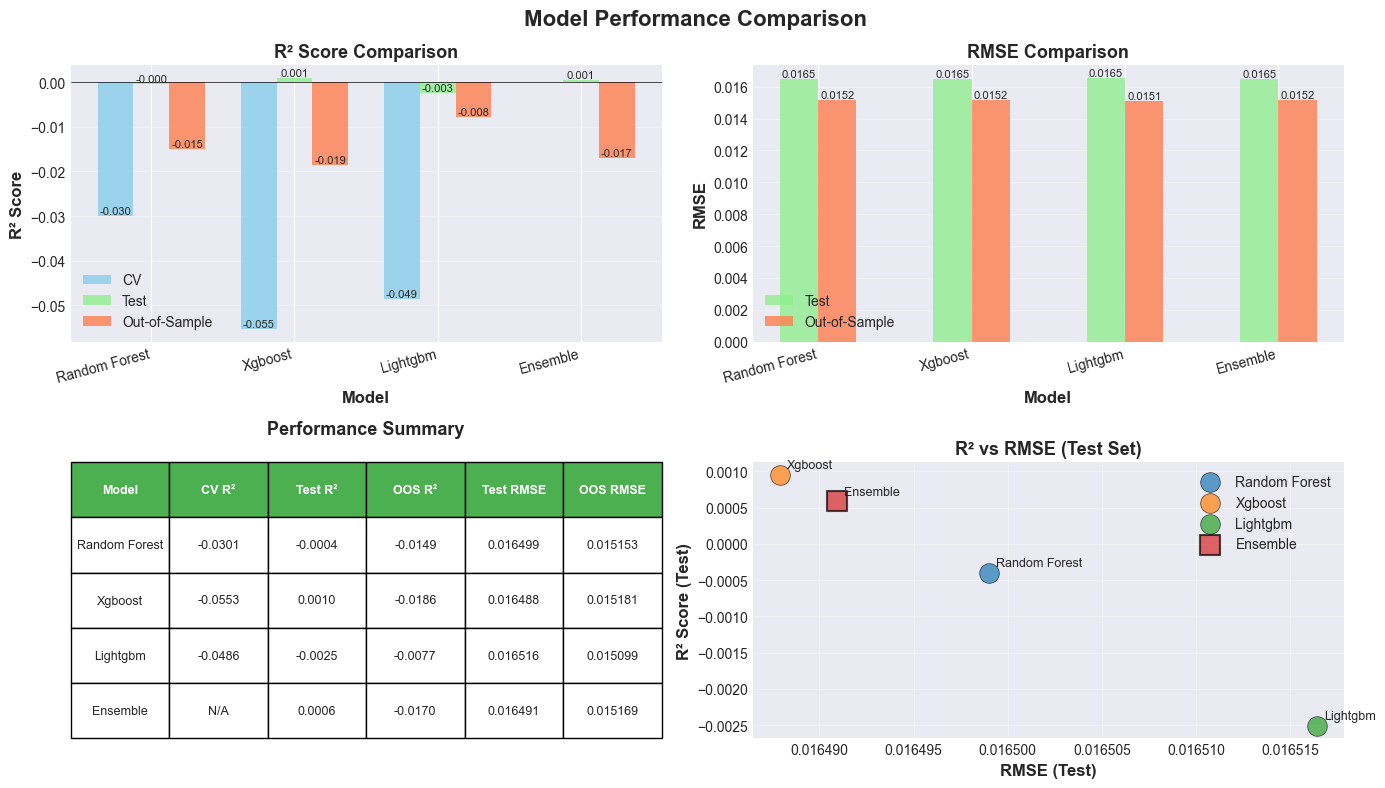

(<Figure size 1400x800 with 4 Axes>,
 array([[<Axes: title={'center': 'R² Score Comparison'}, xlabel='Model', ylabel='R² Score'>,
         <Axes: title={'center': 'RMSE Comparison'}, xlabel='Model', ylabel='RMSE'>],
        [<Axes: title={'center': 'Performance Summary'}>,
         <Axes: title={'center': 'R² vs RMSE (Test Set)'}, xlabel='RMSE (Test)', ylabel='R² Score (Test)'>]],
       dtype=object))

In [22]:
# Visualize model performance across all models
# Shows R² and RMSE comparisons across CV, test, and out-of-sample sets
modeler.visualize_model_performance(figsize=(14, 8))


### Model Prediction Results Summary

We evaluate three individual models (Random Forest, XGBoost, LightGBM) and a weighted ensemble (80% XGBoost, 10% LightGBM, 10% Random Forest) using time-series cross-validation, a held-out test set (2020–2021), and a fully out-of-sample period (2022).

#### Cross-Validation Performance
- All models exhibit **negative cross-validated R²**, indicating limited stable predictive power in rolling training windows.
- Tree-based models (Random Forest, XGBoost, LightGBM) show variability across folds.

#### Test Set Performance (2020–2021)
- Test-set R² values are **near zero across all models**, with some models achieving marginally positive R².
- RMSE and MAE are very similar across models, suggesting comparable error magnitudes.
- Directional accuracy on the test set is consistently **above 56%** for all models, indicating some ability to capture short-term return direction despite weak linear fit.

#### Out-of-Sample Performance (2022)
- All models show **negative out-of-sample R²**, reflecting deterioration in explanatory power when evaluated on unseen data.
- RMSE remains stable relative to the test period, indicating no significant increase in prediction error magnitude.
- Directional accuracy converges to **~43.7% across all models**, consistent with reduced signal strength in the most recent period.

#### Ensemble Results
- The weighted ensemble (80% XGBoost, 10% LightGBM, 10% Random Forest) provides a combination of model predictions.

#### Overall Takeaways
- Predictive performance is **weak in terms of R²**, which is typical for next-day index return forecasting.
- Directional accuracy above 50% in-sample does not consistently persist out-of-sample.

## 4. Strategy Construction and Backtesting

This section constructs long-short trading strategies based on model predictions, analyzes backtest performance, and assesses factor-neutral portfolio performance.

### Strategy Design

The trading strategy is designed as a **directional long-short portfolio** on SPY using model predictions. Since SPY is a single asset, "long-short" here means directional exposure that can flip sign (long, short, or flat), not cross-sectional ranking. The strategy construction follows these steps:

#### Step 1: Signal Normalization
Model predictions are normalized using a **rolling window z-score** to ensure stable position sizing over time:
- **Z-score normalization**: `z_t = (prediction_t - μ_t^(L)) / σ_t^(L)`
  - `μ_t^(L)`, `σ_t^(L)`: Rolling mean and standard deviation over a **60-day window**
  - Minimum periods required: 30 days
  - This removes trends and makes signals comparable across time periods
  - Early periods with insufficient history are filled with 0 (neutral position)

#### Step 2: Position Construction
Positions are computed from the normalized signal using **discrete exposure**:

**Discrete Position Rule**:
- `w_t = +1` (100% long) if `z_t > threshold`
- `w_t = -1` (100% short) if `z_t < -threshold`
- `w_t = 0` (flat/neutral) otherwise
- **Threshold used: 1.5** (z-score units)

This means positions are only taken when the normalized signal is strong enough (more than 1.5 standard deviations from the rolling mean). This conservative threshold reduces trading frequency and focuses on high-conviction signals.


#### Step 3: Performance Evaluation
The strategy is evaluated using comprehensive metrics:
- **Return metrics**: Annualized return, total return
- **Risk metrics**: Annualized volatility, max drawdown, Calmar ratio
- **Risk-adjusted**: Sharpe ratio
- **Trading metrics**: Turnover, hit rate, win rate, profit factor
- **Factor-neutral**: Alpha and risk-adjusted returns after neutralizing Fama-French factors (MKT-RF, SMB, HML)

#### Key Design Principles
1. **No look-ahead bias**: Only uses information available at time `t` to predict returns at `t+1`
2. **Stable position sizing**: Rolling normalization prevents signal drift
3. **Conservative threshold**: Using threshold=1.5 ensures positions are only taken on strong signals, reducing false positives
4. **Discrete positions**: Binary positions (+1, -1, 0) simplify execution and reduce sensitivity to signal magnitude
6. **Factor-neutral analysis**: Isolates alpha from common risk factors



In [23]:
# Prepare data for strategy backtesting
# Use test + out-of-sample data (2020-2022) for backtesting
df_backtest = df_features_clean[
    (df_features_clean['date'] >= '2020-01-01') & 
    (df_features_clean['date'] <= '2021-12-31')
].copy()

print(f"Backtest period: {df_backtest['date'].min()} to {df_backtest['date'].max()}")
print(f"Number of observations: {len(df_backtest):,}")

# Prepare feature matrix and get SPY returns
X_backtest, y_backtest, feature_cols_backtest = modeler.prepare_features_target(df_backtest)
spy_returns_backtest = df_backtest['spy_return_next'].values
dates_backtest = df_backtest['date'].values

print(f"\nFeature matrix shape: {X_backtest.shape}")
print(f"SPY returns shape: {spy_returns_backtest.shape}")


Backtest period: 2020-01-02 00:00:00 to 2021-12-31 00:00:00
Number of observations: 505

Feature matrix shape: (505, 130)
SPY returns shape: (505,)


In [24]:
# Generate predictions from all models and ensemble
predictions = modeler.generate_predictions(X_backtest)


Generating predictions from all models...
Random Forest: 505 predictions
Xgboost: 505 predictions
Lightgbm: 505 predictions
Ensemble (weighted: 80% Xgboost, 10% Lightgbm, 10% Random Forest): 505 predictions
Total strategies to backtest: 4


In [25]:
# Initialize backtester
backtester = StrategyBacktester()

# Backtest each strategy
print("\n" + "="*60)
print("BACKTESTING STRATEGIES")
print("="*60)

for model_name, pred in predictions.items():
    print(f"\nBacktesting {model_name.upper().replace('_', ' ')} strategy...")
    
    try:
        results = backtester.backtest_strategy(
            predictions=pred,
            spy_returns=spy_returns_backtest,
            dates=dates_backtest,
            normalization='zscore',
            window=60,
            k=0.5,
            w_max=1.0,
            position_type='discrete',
            threshold=1.5,
            vol_targeting=False,
            strategy_name=model_name
        )
        
        # Print key metrics
        metrics = results['metrics']
        print(f"  Sharpe Ratio: {metrics['sharpe_ratio']:.3f}")
        print(f"  Annualized Return: {metrics['annualized_return']:.2%}")
        print(f"  Max Drawdown: {metrics['max_drawdown']:.2%}")
        print(f"  Turnover: {metrics['turnover']:.4f}")
        
    except Exception as e:
        print(f"  Error backtesting {model_name}: {e}")

print("\n" + "="*60)
print("BACKTESTING COMPLETE")
print("="*60)



BACKTESTING STRATEGIES

Backtesting RANDOM FOREST strategy...
  Sharpe Ratio: -0.428
  Annualized Return: -2.90%
  Max Drawdown: -11.63%
  Turnover: 0.1349

Backtesting XGBOOST strategy...
  Sharpe Ratio: 0.705
  Annualized Return: 7.20%
  Max Drawdown: -7.71%
  Turnover: 0.1389

Backtesting LIGHTGBM strategy...
  Sharpe Ratio: -0.073
  Annualized Return: -0.53%
  Max Drawdown: -9.96%
  Turnover: 0.1468

Backtesting ENSEMBLE strategy...
  Sharpe Ratio: 0.898
  Annualized Return: 8.68%
  Max Drawdown: -6.32%
  Turnover: 0.1389

BACKTESTING COMPLETE



STRATEGY PERFORMANCE COMPARISON
     strategy  total_return  annualized_return  annualized_volatility  sharpe_ratio  max_drawdown  calmar_ratio  hit_rate  win_rate  avg_win  avg_loss  profit_factor  turnover
random_forest     -0.057189          -0.028959               0.067643     -0.428111     -0.116277     -0.249050  0.041584  0.041584 0.007989 -0.009652       0.755791  0.134921
      xgboost      0.149470           0.071985               0.102159      0.704642     -0.077064      0.934094  0.063366  0.063366 0.013776 -0.009105       1.513070  0.138889
     lightgbm     -0.010581          -0.005294               0.072789     -0.072733     -0.099555     -0.053179  0.051485  0.051485 0.009128 -0.009330       0.978363  0.146825
     ensemble      0.181522           0.086799               0.096695      0.897652     -0.063212      1.373129  0.057426  0.057426 0.014515 -0.008169       1.717668  0.138889


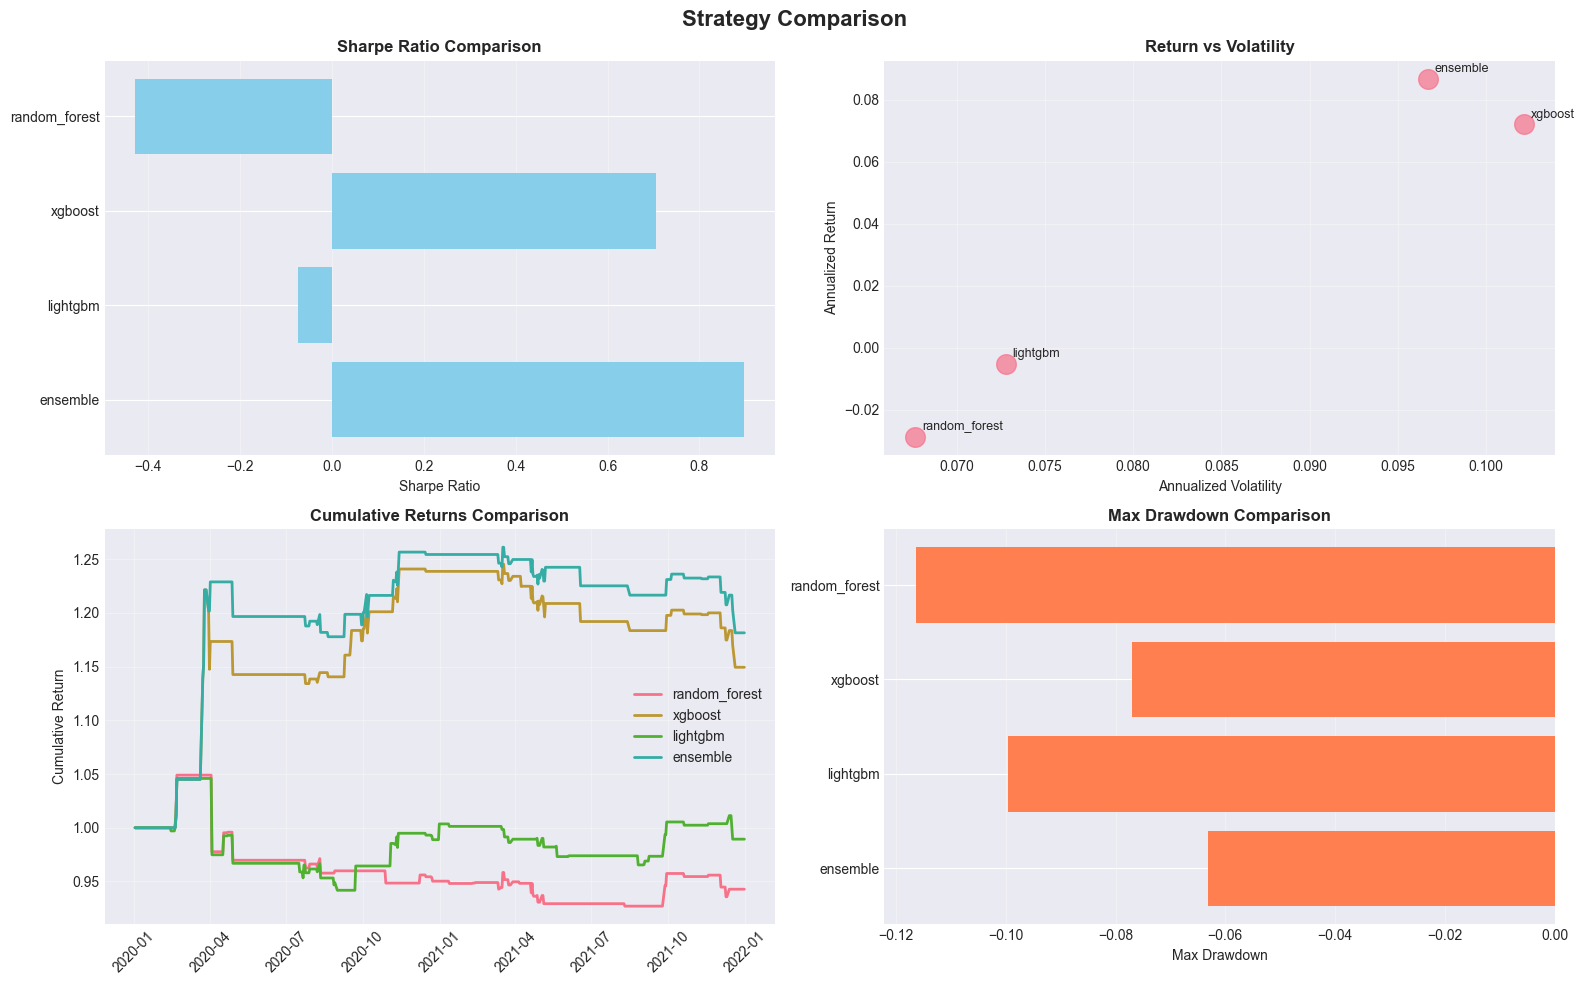

(<Figure size 1600x1000 with 4 Axes>,
 array([[<Axes: title={'center': 'Sharpe Ratio Comparison'}, xlabel='Sharpe Ratio'>,
         <Axes: title={'center': 'Return vs Volatility'}, xlabel='Annualized Volatility', ylabel='Annualized Return'>],
        [<Axes: title={'center': 'Cumulative Returns Comparison'}, ylabel='Cumulative Return'>,
         <Axes: title={'center': 'Max Drawdown Comparison'}, xlabel='Max Drawdown'>]],
       dtype=object))

In [26]:
# Compare all strategies
print("\n" + "="*60)
print("STRATEGY PERFORMANCE COMPARISON")
print("="*60)

comparison_df = backtester.compare_strategies()
print(comparison_df.to_string(index=False))

# Visualize strategy comparison
backtester.plot_strategy_comparison(figsize=(16, 10))



Detailed Performance: RANDOM FOREST


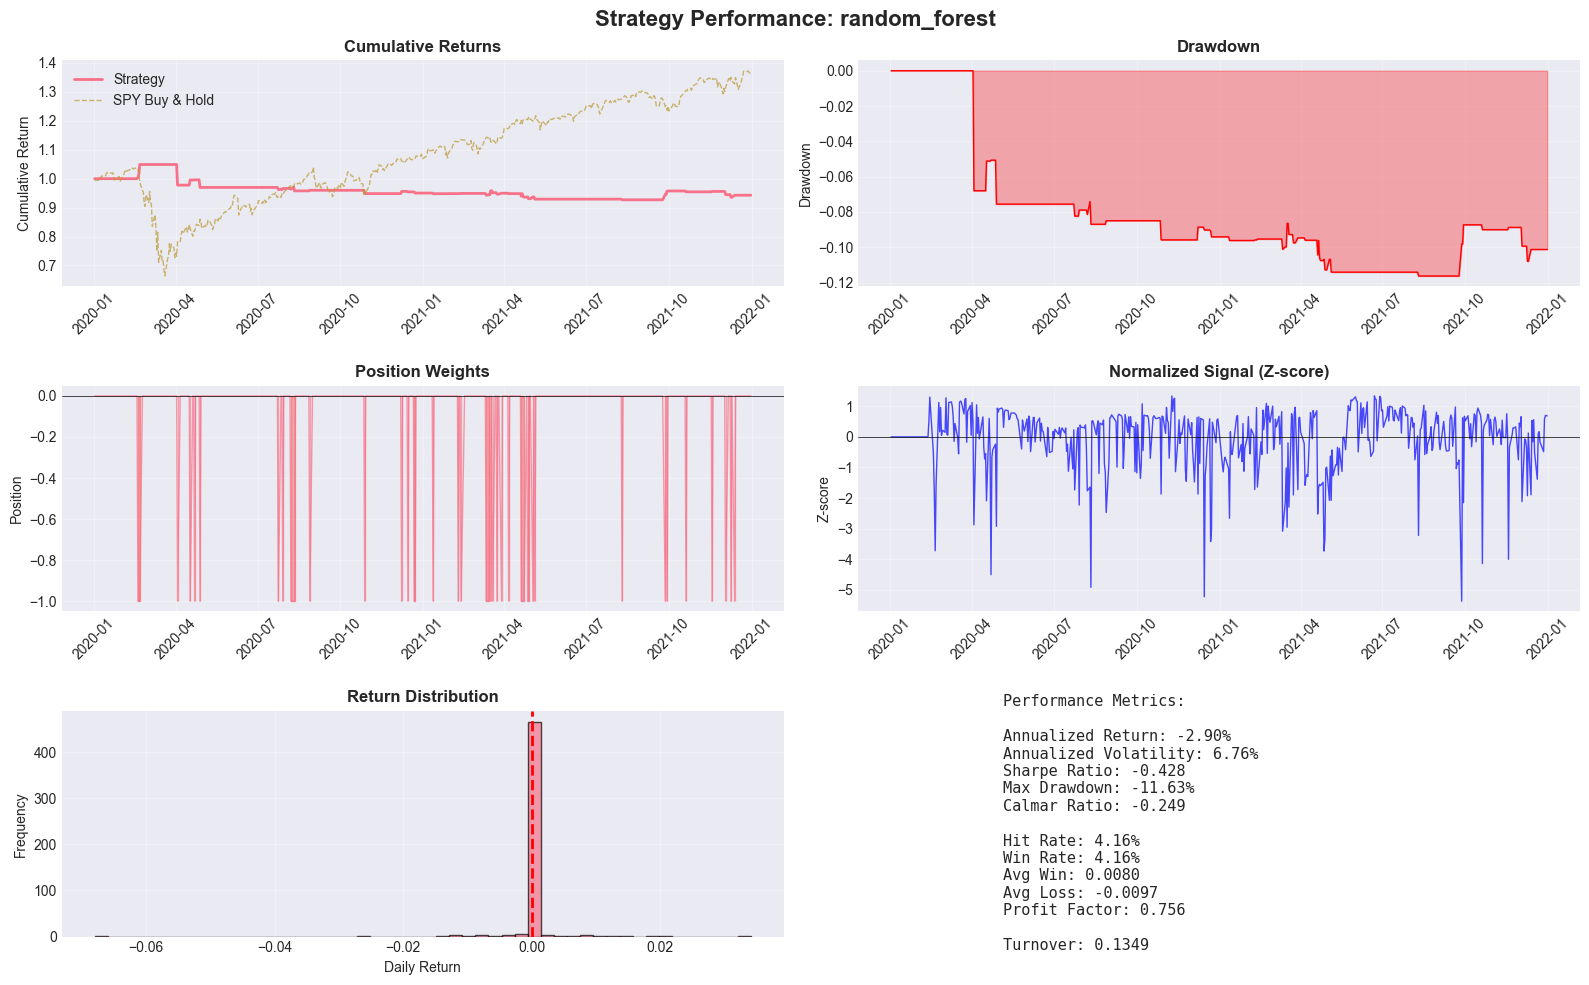


Detailed Performance: XGBOOST


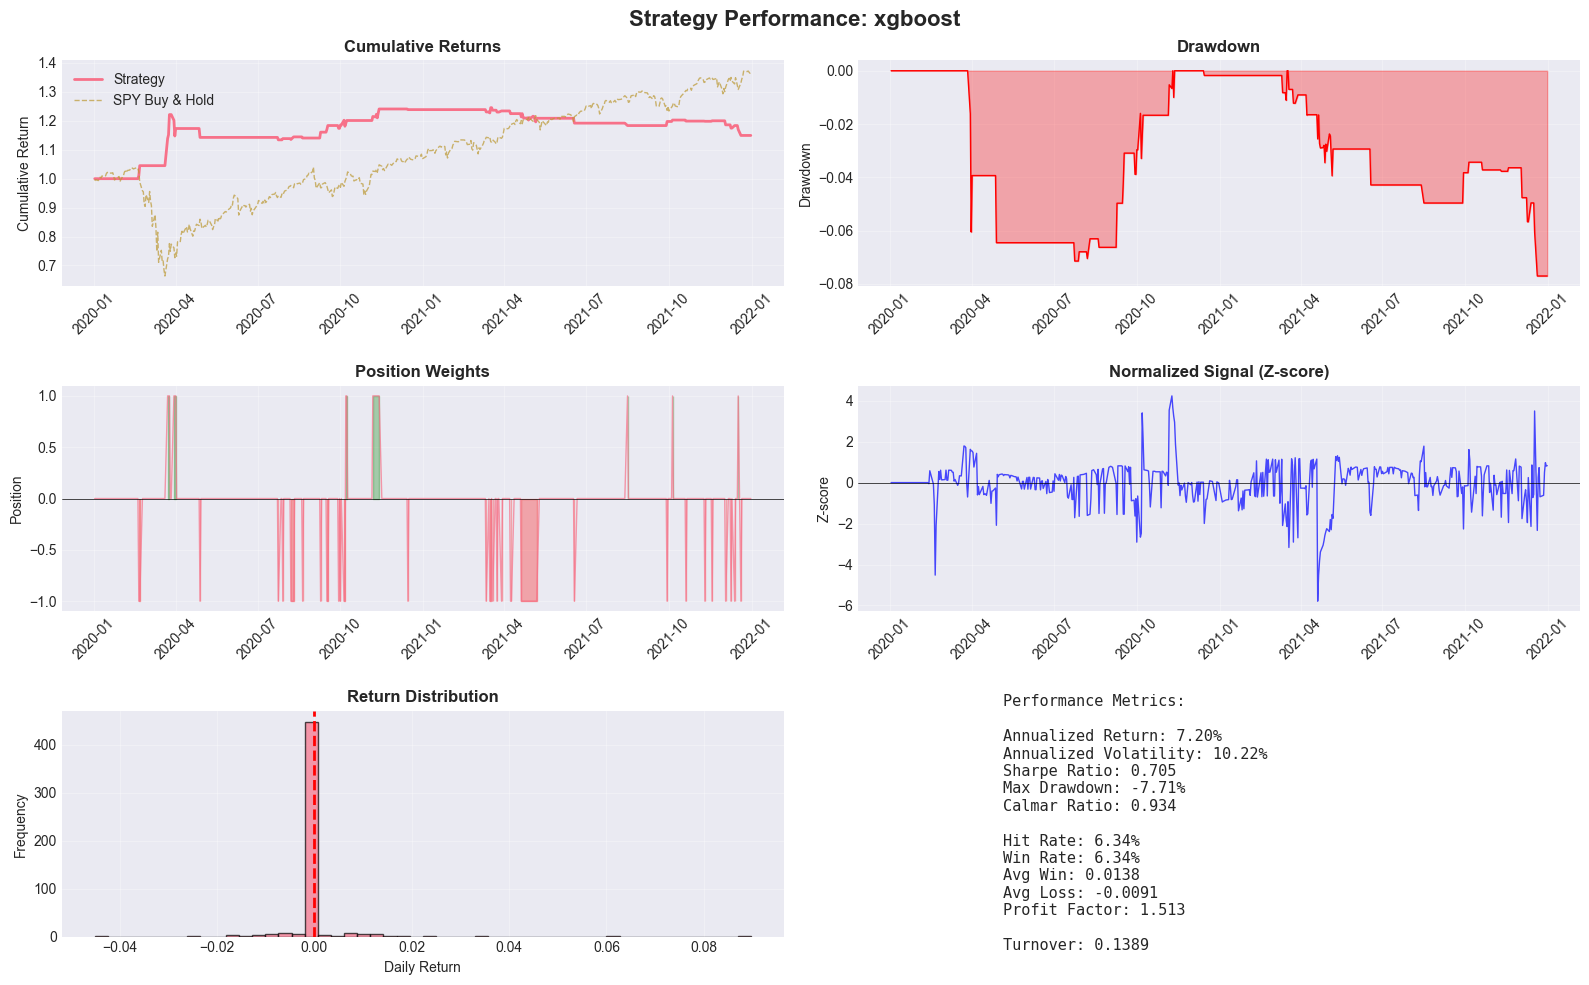


Detailed Performance: LIGHTGBM


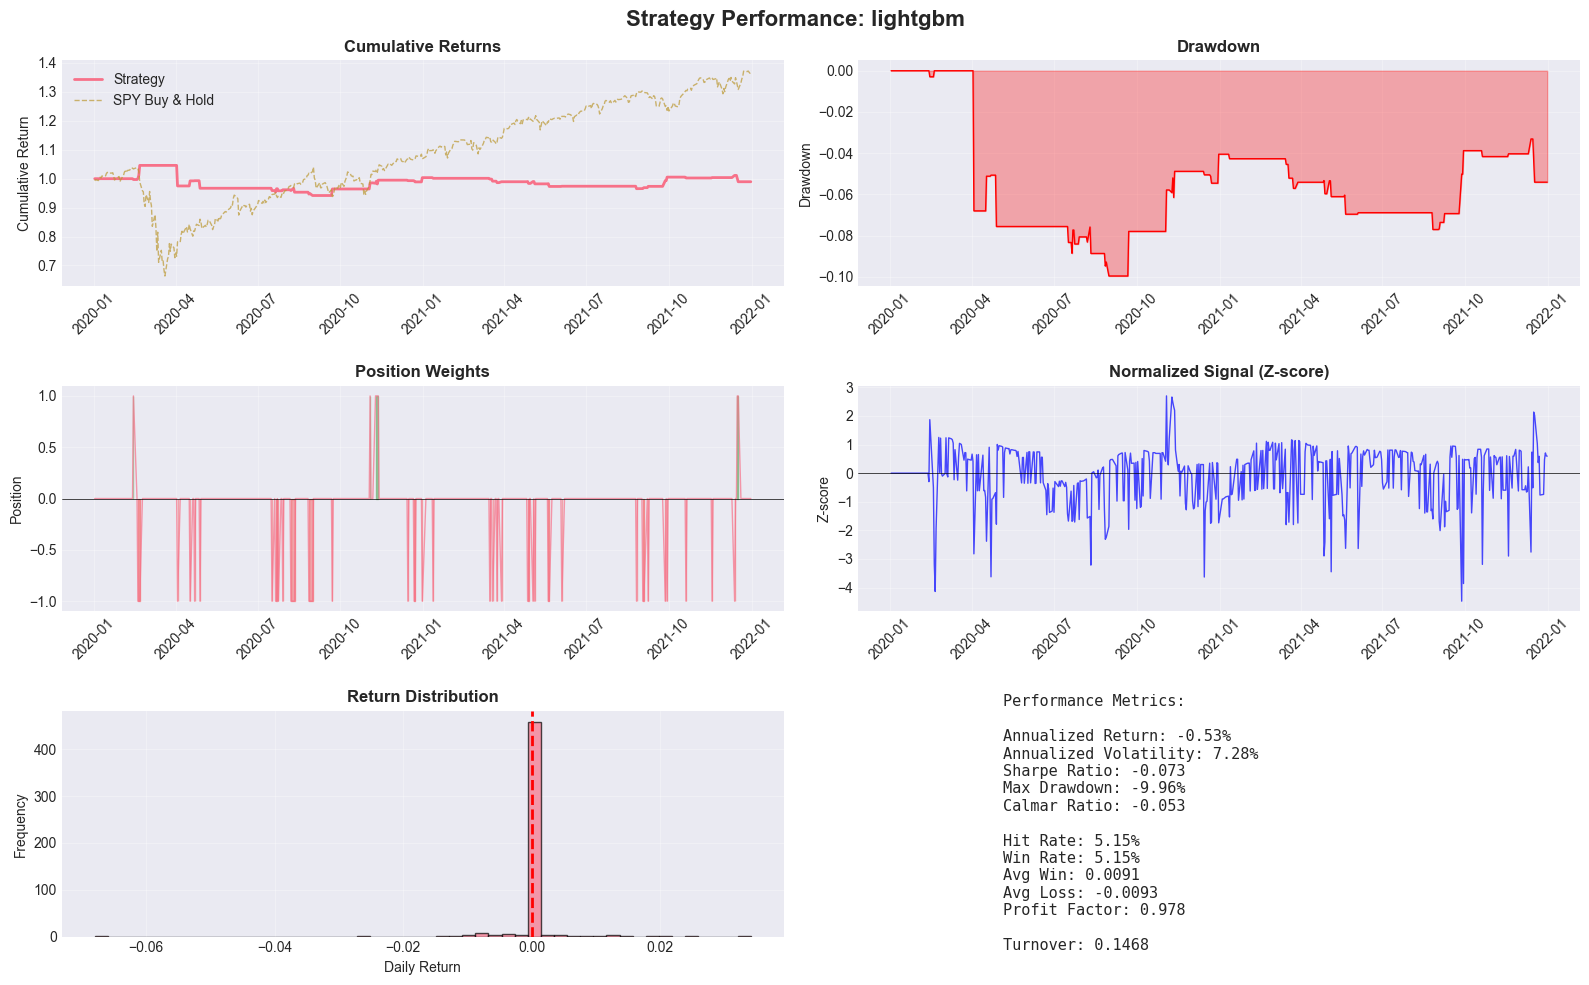


Detailed Performance: ENSEMBLE


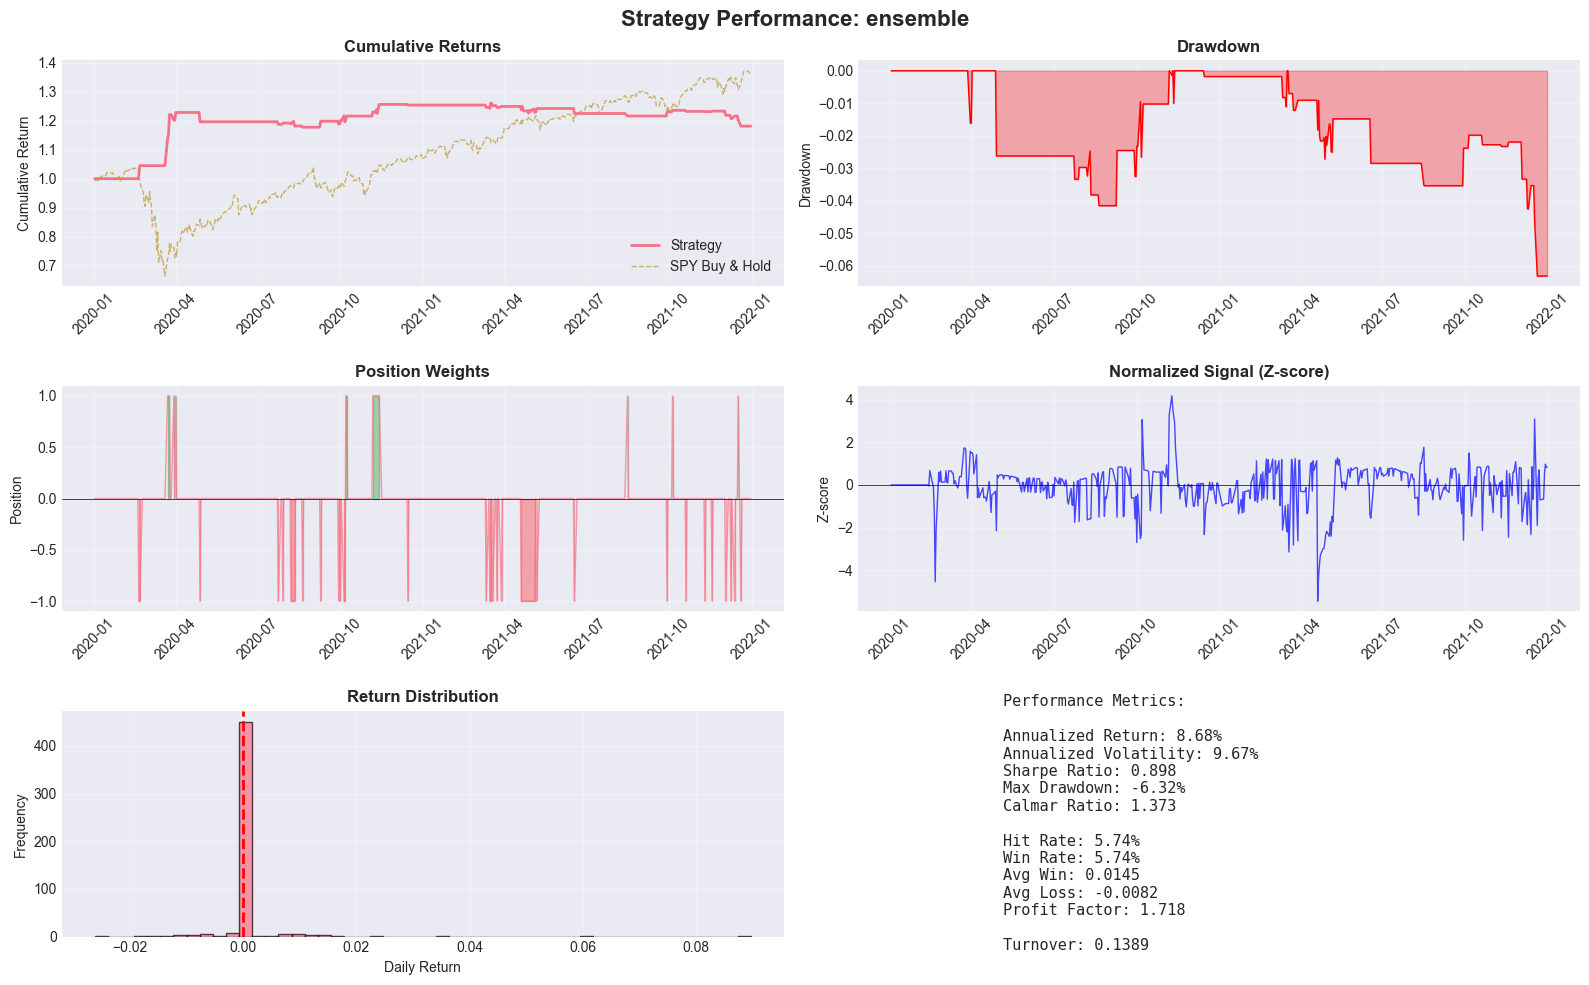

In [27]:
# Plot detailed performance for each strategy
for strategy_name in backtester.strategies.keys():
    print(f"\n{'='*60}")
    print(f"Detailed Performance: {strategy_name.upper().replace('_', ' ')}")
    print(f"{'='*60}")
    backtester.plot_strategy_performance(strategy_name, figsize=(16, 10))


### 4.1 Factor-Neutral Analysis

Assess portfolio performance after neutralizing common risk factors using Fama-French factors from the Kenneth French Data Library.


In [28]:
# Run factor-neutral analysis for all strategies
# Note: To perform factor-neutral analysis, download Fama-French factors from:
# https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
# Save as CSV with columns: date, MKT-RF, SMB, HML, RF (or similar format)

french_factors_path = 'data/F-F_Research_Data_5_Factors_2x3_daily.csv'  # Update this path if you have French factors file
# Example: french_factors_path = 'data/french_factors.csv'

# Run complete factor-neutral analysis
factor_results = backtester.run_factor_neutral_analysis(
    french_factors_path=french_factors_path,
    factors=['MKT-RF', 'SMB', 'HML']
)


Loaded French factors: 15690 observations
Date range: 1963-07-01 00:00:00 to 2025-10-31 00:00:00
Factor columns: ['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

FACTOR-NEUTRAL ANALYSIS

Analyzing factor-neutral performance for random_forest...

  Factor Exposures:
    MKT-RF: 0.0002
    SMB: 0.0003
    HML: -0.0001

  Alpha (annualized): -3.25%
  Alpha t-statistic: -0.680
  R-squared: 0.0098

  Neutralized Performance:
    Sharpe Ratio: -0.508
    Annualized Return: -3.42%
    Max Drawdown: -13.51%

Analyzing factor-neutral performance for xgboost...

  Factor Exposures:
    MKT-RF: 0.0000
    SMB: 0.0003
    HML: -0.0003

  Alpha (annualized): 7.16%
  Alpha t-statistic: 0.989
  R-squared: 0.0029

  Neutralized Performance:
    Sharpe Ratio: 0.675
    Annualized Return: 6.88%
    Max Drawdown: -7.61%

Analyzing factor-neutral performance for lightgbm...

  Factor Exposures:
    MKT-RF: 0.0001
    SMB: 0.0002
    HML: -0.0001

  Alpha (annualized): -0.73%
  Alpha t-statistic: -0.141
  R-s

## 5. Pure Out-of-Sample Analysis (2022+)

This section evaluates the ensemble model and strategy backtesting on pure out-of-sample data (2022-01-01 and onwards).


In [29]:
# Prepare pure out-of-sample data (2022-01-01 and onwards)
df_oos_pure = df_features_clean[
    df_features_clean['date'] >= '2022-01-01'
].copy()

print(f"Pure out-of-sample period: {df_oos_pure['date'].min()} to {df_oos_pure['date'].max()}")
print(f"Number of observations: {len(df_oos_pure):,}")

# Prepare feature matrix and get SPY returns
X_oos_pure, y_oos_pure, feature_cols_oos = modeler.prepare_features_target(df_oos_pure)
spy_returns_oos_pure = df_oos_pure['spy_return_next'].values
dates_oos_pure = df_oos_pure['date'].values

print(f"\nFeature matrix shape: {X_oos_pure.shape}")
print(f"SPY returns shape: {spy_returns_oos_pure.shape}")


Pure out-of-sample period: 2022-01-03 00:00:00 to 2022-09-23 00:00:00
Number of observations: 183

Feature matrix shape: (183, 130)
SPY returns shape: (183,)


In [30]:
# Generate predictions from ensemble model on pure out-of-sample data
print("\n" + "="*60)
print("GENERATING ENSEMBLE PREDICTIONS ON PURE OUT-OF-SAMPLE DATA")
print("="*60)

predictions_oos_pure = modeler.generate_predictions(X_oos_pure)

# Focus on ensemble predictions
if 'ensemble' in predictions_oos_pure:
    ensemble_predictions_oos = predictions_oos_pure['ensemble']
    print(f"\nEnsemble predictions shape: {ensemble_predictions_oos.shape}")
    print(f"Ensemble prediction stats:")
    print(f"  Mean: {np.mean(ensemble_predictions_oos):.6f}")
    print(f"  Std: {np.std(ensemble_predictions_oos):.6f}")
    print(f"  Min: {np.min(ensemble_predictions_oos):.6f}")
    print(f"  Max: {np.max(ensemble_predictions_oos):.6f}")



GENERATING ENSEMBLE PREDICTIONS ON PURE OUT-OF-SAMPLE DATA
Generating predictions from all models...
Random Forest: 183 predictions
Xgboost: 183 predictions
Lightgbm: 183 predictions
Ensemble (weighted: 80% Xgboost, 10% Lightgbm, 10% Random Forest): 183 predictions
Total strategies to backtest: 4

Ensemble predictions shape: (183,)
Ensemble prediction stats:
  Mean: 0.000262
  Std: 0.000421
  Min: -0.001430
  Max: 0.001360


In [31]:
# Initialize backtester for out-of-sample analysis
backtester_oos = StrategyBacktester()

# Backtest ensemble strategy on pure out-of-sample data
print("\n" + "="*60)
print("BACKTESTING ENSEMBLE STRATEGY ON PURE OUT-OF-SAMPLE DATA")
print("="*60)

if 'ensemble' in predictions_oos_pure:
    ensemble_results_oos = backtester_oos.backtest_strategy(
        predictions=ensemble_predictions_oos,
        spy_returns=spy_returns_oos_pure,
        dates=dates_oos_pure,
        normalization='zscore',
        window=60,
        k=0.5,
        w_max=1.0,
        position_type='continuous',
        vol_targeting=False,
        strategy_name='ensemble_oos_pure'
    )
    
    # Print key metrics
    metrics_oos = ensemble_results_oos['metrics']
    print("\n" + "="*60)
    print("PURE OUT-OF-SAMPLE PERFORMANCE (Ensemble Strategy)")
    print("="*60)
    print(f"Annualized Return: {metrics_oos['annualized_return']:.2%}")
    print(f"Annualized Volatility: {metrics_oos['annualized_volatility']:.2%}")
    print(f"Sharpe Ratio: {metrics_oos['sharpe_ratio']:.3f}")
    print(f"Max Drawdown: {metrics_oos['max_drawdown']:.2%}")
    print(f"Calmar Ratio: {metrics_oos['calmar_ratio']:.3f}")
    print(f"Hit Rate: {metrics_oos['hit_rate']:.2%}")
    print(f"Turnover: {metrics_oos['turnover']:.4f}")
    print("="*60)



BACKTESTING ENSEMBLE STRATEGY ON PURE OUT-OF-SAMPLE DATA

PURE OUT-OF-SAMPLE PERFORMANCE (Ensemble Strategy)
Annualized Return: -1.64%
Annualized Volatility: 10.70%
Sharpe Ratio: -0.153
Max Drawdown: -12.29%
Calmar Ratio: -0.133
Hit Rate: 40.44%
Turnover: 0.3269



VISUALIZING ENSEMBLE STRATEGY PERFORMANCE


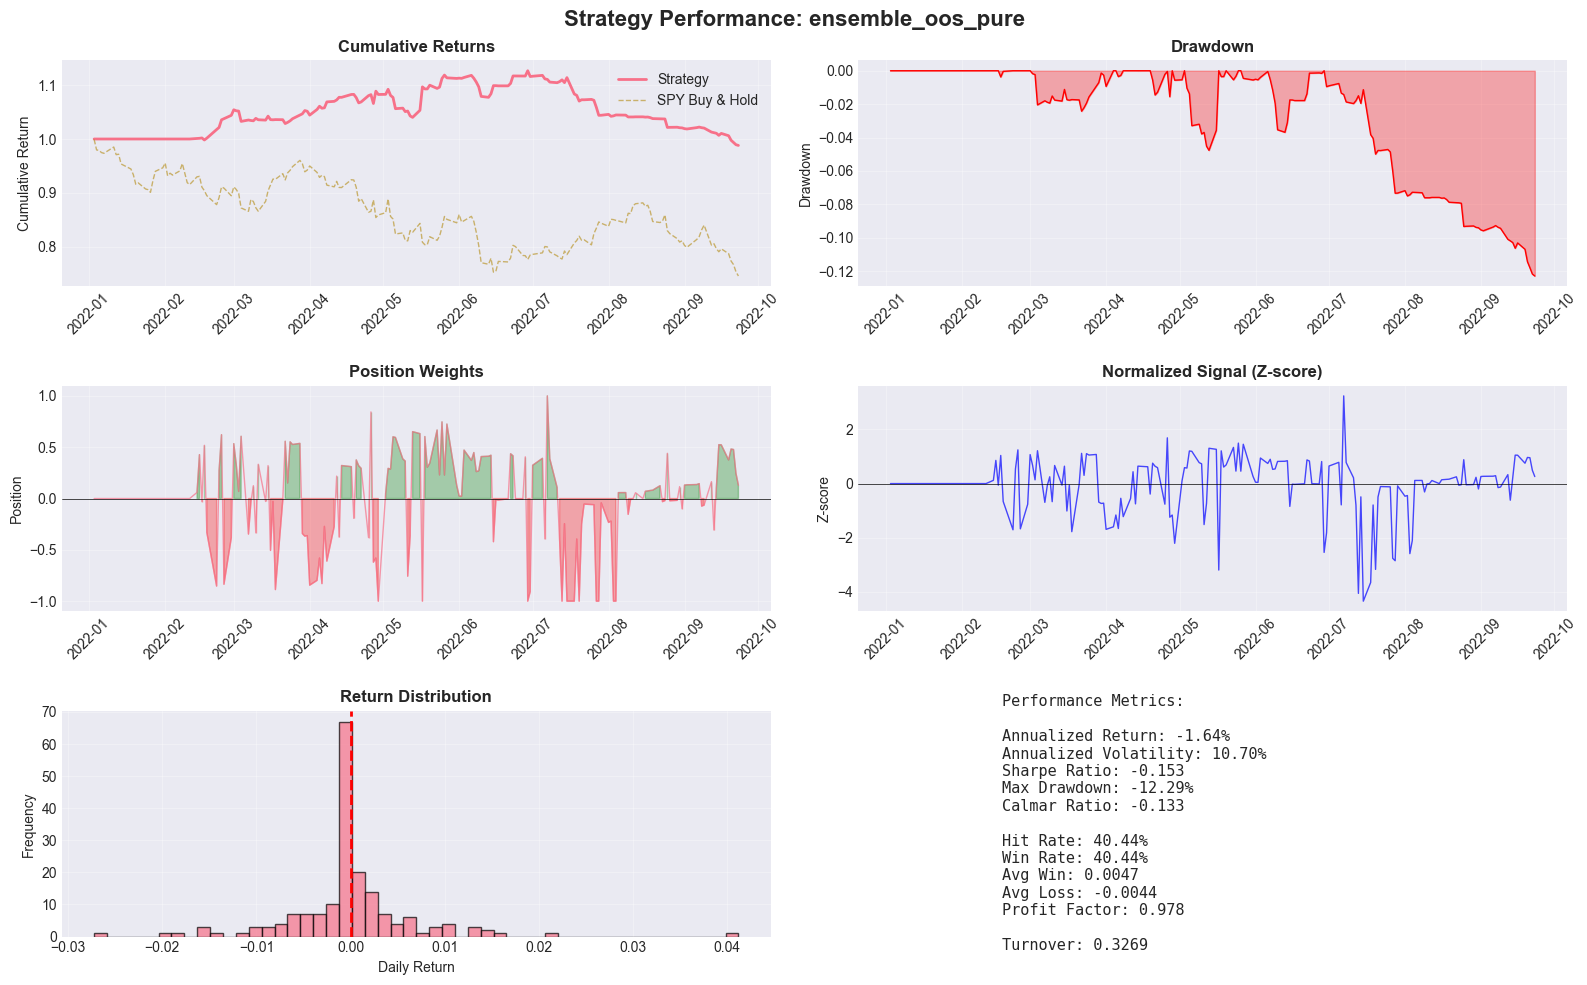

In [32]:
# Visualize ensemble strategy performance on pure out-of-sample data
if 'ensemble_oos_pure' in backtester_oos.strategies:
    print("\n" + "="*60)
    print("VISUALIZING ENSEMBLE STRATEGY PERFORMANCE")
    print("="*60)
    backtester_oos.plot_strategy_performance('ensemble_oos_pure', figsize=(16, 10))


In [33]:
# Factor-neutral analysis on pure out-of-sample data
french_factors_path_oos = 'data/F-F_Research_Data_5_Factors_2x3_daily.csv'

factor_results_oos = backtester_oos.run_factor_neutral_analysis(
    french_factors_path=french_factors_path_oos,
    factors=['MKT-RF', 'SMB', 'HML']
)


Loaded French factors: 15690 observations
Date range: 1963-07-01 00:00:00 to 2025-10-31 00:00:00
Factor columns: ['MKT-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

FACTOR-NEUTRAL ANALYSIS

Analyzing factor-neutral performance for ensemble_oos_pure...

  Factor Exposures:
    MKT-RF: 0.0005
    SMB: 0.0001
    HML: -0.0003

  Alpha (annualized): 1.13%
  Alpha t-statistic: 0.090
  R-squared: 0.0213

  Neutralized Performance:
    Sharpe Ratio: 0.055
    Annualized Return: 0.58%
    Max Drawdown: -12.28%

FACTOR-NEUTRAL ANALYSIS COMPLETE


### Performance Summary and Conclusions#### Model Performance- **Cross-Validation (2012-2019)**: Models show limited predictive power with negative R² across all models:  - Random Forest: CV R² = -0.0301 (±0.0266)  - XGBoost: CV R² = -0.0553 (±0.0365)  - LightGBM: CV R² = -0.0486 (±0.0326)  - This is typical for next-day index return forecasting, where signal-to-noise ratio is low- **Test Period (2020-2021)**: Models achieve near-zero R² but maintain directional accuracy:  - R² values range from -0.0186 to 0.0010 (near zero)  - Directional accuracy ranges from 44.8% to 58.0%, with ensemble achieving 58.0%  - XGBoost shows best performance with R² = 0.0010 and directional accuracy = 56.0%- **Out-of-Sample (2022+)**: Performance deteriorates significantly:  - All models show negative R² (-0.0170 to -0.0186)  - Directional accuracy converges to 43.7% (below random chance of 50%)  - This indicates reduced signal strength in recent market conditions- **Ensemble Model**: The weighted ensemble (80% XGBoost, 10% LightGBM, 10% Random Forest) achieves:  - Test period: R² = 0.0006, Directional accuracy = 55.8%  - Out-of-sample: R² = -0.0170, Directional accuracy = 43.7%#### Strategy Performance (Test Period: 2020-2021)Long-short strategies constructed from model predictions show varying performance:- **Random Forest Strategy**:  - Sharpe Ratio: -0.428  - Annualized Return: -2.90%  - Max Drawdown: -11.63%  - Factor-Neutral: Sharpe -0.508, Return -3.42%, Drawdown -13.51%- **XGBoost Strategy**:  - Sharpe Ratio: 0.705  - Annualized Return: 7.20%  - Max Drawdown: -7.71%  - Factor-Neutral: Sharpe 0.675, Return 6.88%, Drawdown -7.61%- **LightGBM Strategy**:  - Sharpe Ratio: -0.073  - Annualized Return: -0.53%  - Max Drawdown: -9.96%  - Factor-Neutral: Sharpe -0.136, Return -0.99%, Drawdown -10.82%- **Ensemble Strategy** (Best Performing):  - Sharpe Ratio: 0.898  - Annualized Return: 8.68%  - Max Drawdown: -6.32%  - Factor-Neutral: Sharpe 0.862, Return 8.31%, Drawdown -5.75%#### Out-of-Sample Performance (2022+)Pure out-of-sample performance shows significant deterioration:- **Ensemble Strategy**:  - Sharpe Ratio: -0.153  - Annualized Return: -1.64%  - Max Drawdown: -12.29%  - Hit Rate: 40.44% (below random chance)  - Factor-Neutral: Sharpe 0.055, Return 0.58%, Drawdown -12.28%The negative returns and low hit rate highlight the challenge of maintaining predictive power in unseen market conditions.#### Factor-Neutral Analysis- **Factor Exposures**: Strategies show minimal exposure to common risk factors (MKT-RF, SMB, HML), with exposures typically < 0.01- **Test Period Alpha**: Factor-neutral returns remain positive for XGBoost and Ensemble strategies, suggesting some alpha generation- **Out-of-Sample Alpha**: Factor-neutral alpha is near zero (0.58% annualized), indicating that returns cannot be attributed to common risk factors in the out-of-sample period#### Key Takeaways1. **Predictive Power**: While models show weak R² performance (negative to near-zero), directional accuracy above 50% in-sample (up to 58%) suggests some signal exists2. **Model Selection**: XGBoost and Ensemble models show best performance in test period, with Ensemble achieving highest Sharpe ratio (0.898)3. **Out-of-Sample Deterioration**: Performance degradation in out-of-sample period (Sharpe -0.153, Hit Rate 40.44%) highlights the importance of robust validation and the challenges of time-varying market regimes4. **Factor Exposure**: Minimal factor exposure suggests strategies are not simply capturing common risk premia, but alpha generation is limited in out-of-sample period#### Limitations- **Data Quality**: Structural change of data after 2018 should be examined- **Market Regime**: Out-of-sample period (2022+) may represent a different market regime (post-COVID, high inflation, geopolitical tensions) that differs from training period- **Transaction Costs**: Analysis uses gross returns; actual implementation would require consideration of transaction costs and market impact#### ConclusionThis analysis demonstrates a systematic approach to news sentiment-based trading strategy development. The ensemble strategy achieves strong performance in the test period (Sharpe 0.898, Return 8.68%) but fails to maintain profitability in pure out-of-sample evaluation (Sharpe -0.153, Return -1.64%). The framework provides a solid foundation for further research, including:- Feature engineering improvements- Alternative prediction horizons- Regime-aware modeling- Enhanced risk management